In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
#plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
from numpy.fft import fft2

In [3]:
filter_bank2D = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/data')
filter_bank2D_J_L = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/J_L')
filter_bank2D_psi_index = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/psi_index')
filter_bank2D_phi_index = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/phi_index')

Figure 1

In [4]:
import matplotlib.colors as mcolors
colors = [(0.8,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,0.7,0,c) for c in np.linspace(0,1,100)]
cmapgreen = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colormaps = [cmapred,cmapblue,cmapgreen]

In [5]:
from scipy.ndimage import map_coordinates

In [6]:
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad

def drawCirc(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    #========Line
    arc = Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,color=color_) #capstyle='round',linestyle='-',lw=10
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        RegularPolygon(
            (endX, endY),            # (x,y)
            3,                       # number of vertices
            radius/25,                # radius
            rad(angle_+theta2_),     # orientation
            color=color_
        )
    )
    #ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 
    # Make sure you keep the axes scaled or else arrow will distort

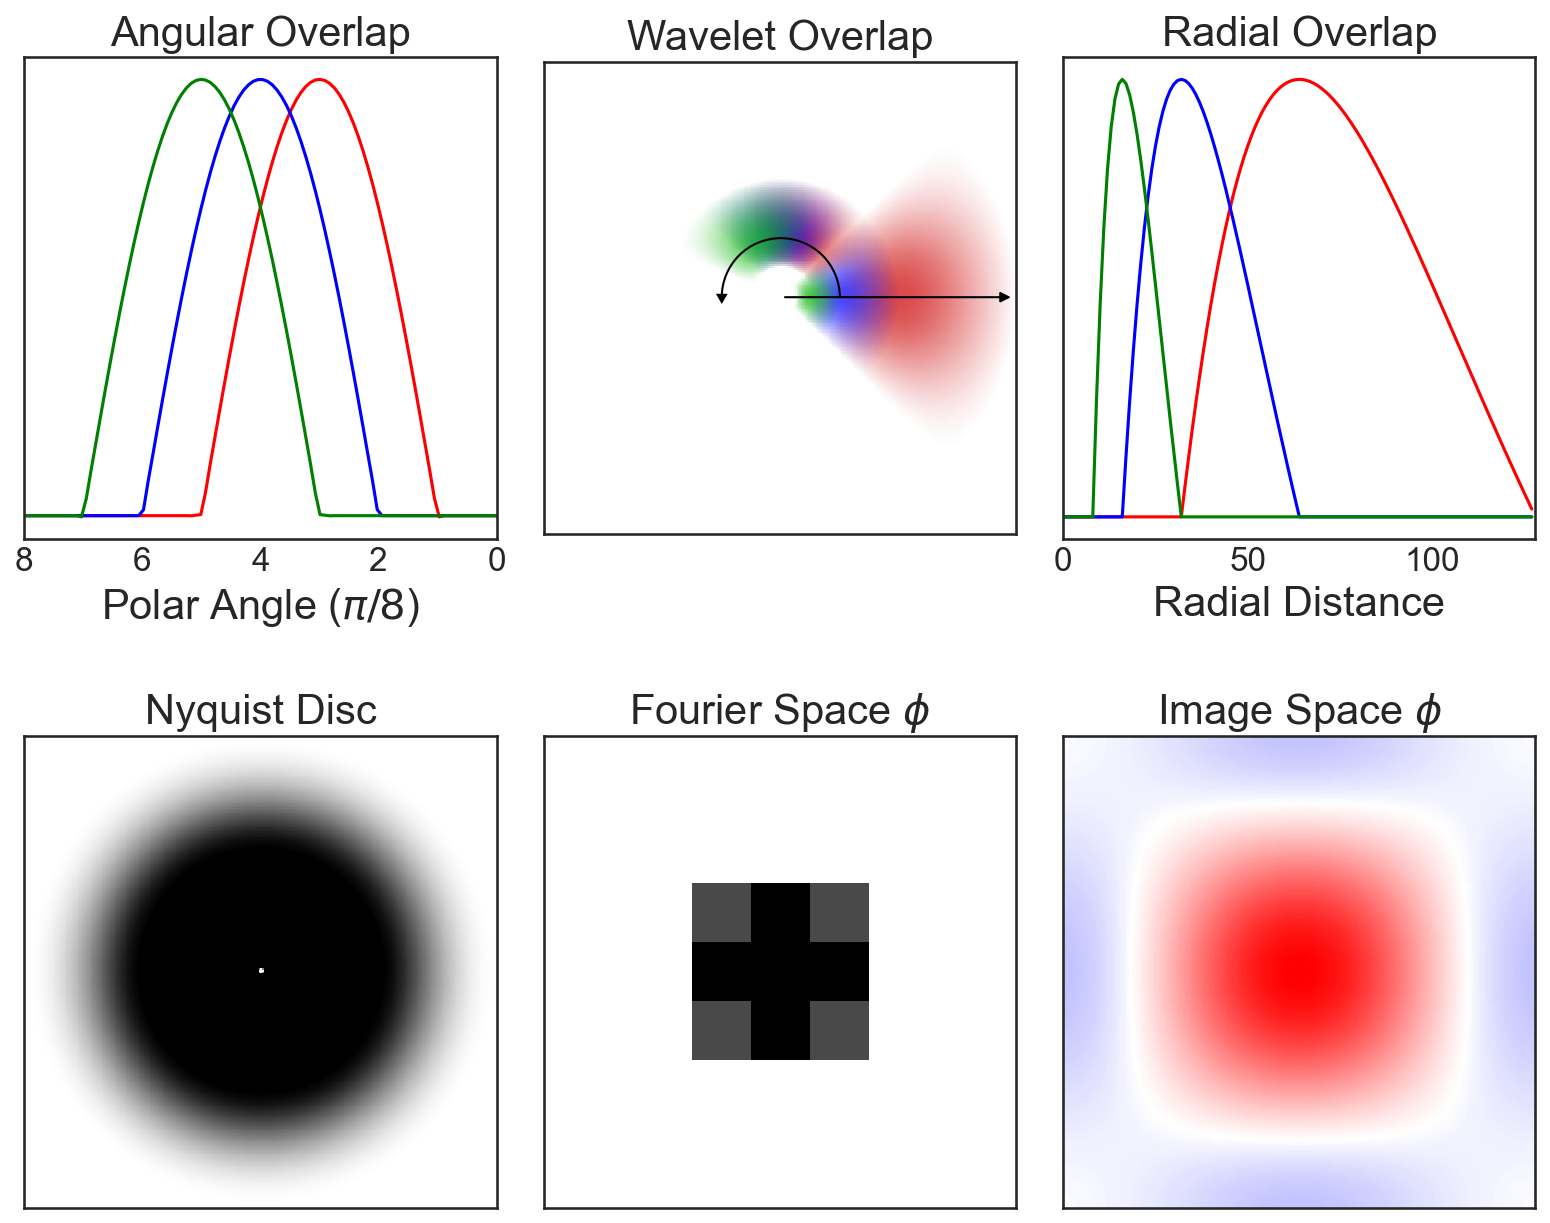

In [9]:
## Figure 1
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(13,10), dpi=150)

ax = fig.add_subplot(2,3,2)
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[jind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
ax.axes.set_title('Wavelet Overlap')

ax.annotate("",
            xy=(255, 128), xycoords='data',
            xytext=(128, 128), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3",
                            color='k'),
            )

drawCirc(ax,64,128,128,0,180)

colormaps = [cmapred,cmapblue,cmapgreen]
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[lind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,3)
color_opt = ['red','blue','green']
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    plt.plot(np.fft.fftshift(data).T[128,128:],color=color_opt[jind])
    ax.axes.yaxis.set_ticks([])
    ax.set_xlim(0,128)
ax.axes.set_xlabel('Radial Distance')
ax.axes.set_title('Radial Overlap')

ax = fig.add_subplot(2,3,1)
color_opt = ['red','blue','green']
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    data = np.fft.fftshift(data)
    
    t = np.linspace(np.pi,0,100)
    r = 32
    xc = 128
    yc = 128
    x = r*np.cos(t) + xc
    y = r*np.sin(t) + yc
    zi_fink = map_coordinates(data, np.vstack((x,y)))
    plt.plot(t/np.pi*8,zi_fink,color=color_opt[lind])
    ax.set_xlim(8, 0)
    ax.axes.yaxis.set_ticks([])
ax.axes.set_xlabel('Polar Angle ($\pi/8$)')
ax.axes.set_title('Angular Overlap')

ax = fig.add_subplot(2,3,4)
total_im_energy = np.zeros((256,256))
for j in range(6):
    for l in range(16):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1].T
        total_im_energy += np.fft.fftshift(data)**2

ax.imshow(
    total_im_energy,
    vmin=0,
    #vmax=1,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal',
    alpha=1
)
ax.axes.set_title('Nyquist Disc')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,5)

data = filter_bank2D[filter_bank2D_phi_index[0]-1].T
scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])

j=5
ax.imshow(
    np.fft.fftshift(data),
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.set_title('Fourier Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])

ax = fig.add_subplot(2,3,6)
ax.imshow(
    np.real(np.fft.fftshift(fft2(data)).T),
    vmin=-scale,
    vmax=scale,
    origin='lower',
    interpolation='nearest',
    cmap='bwr',
    aspect='equal'
)
ax.axes.set_title('Image Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(np.abs(j+2)),128+2**(np.abs(j+2))])
ax.axes.set_ylim([128-2**(np.abs(j+2)),128+2**(np.abs(j+2))])

fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig('../figures/FinkletOrient.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

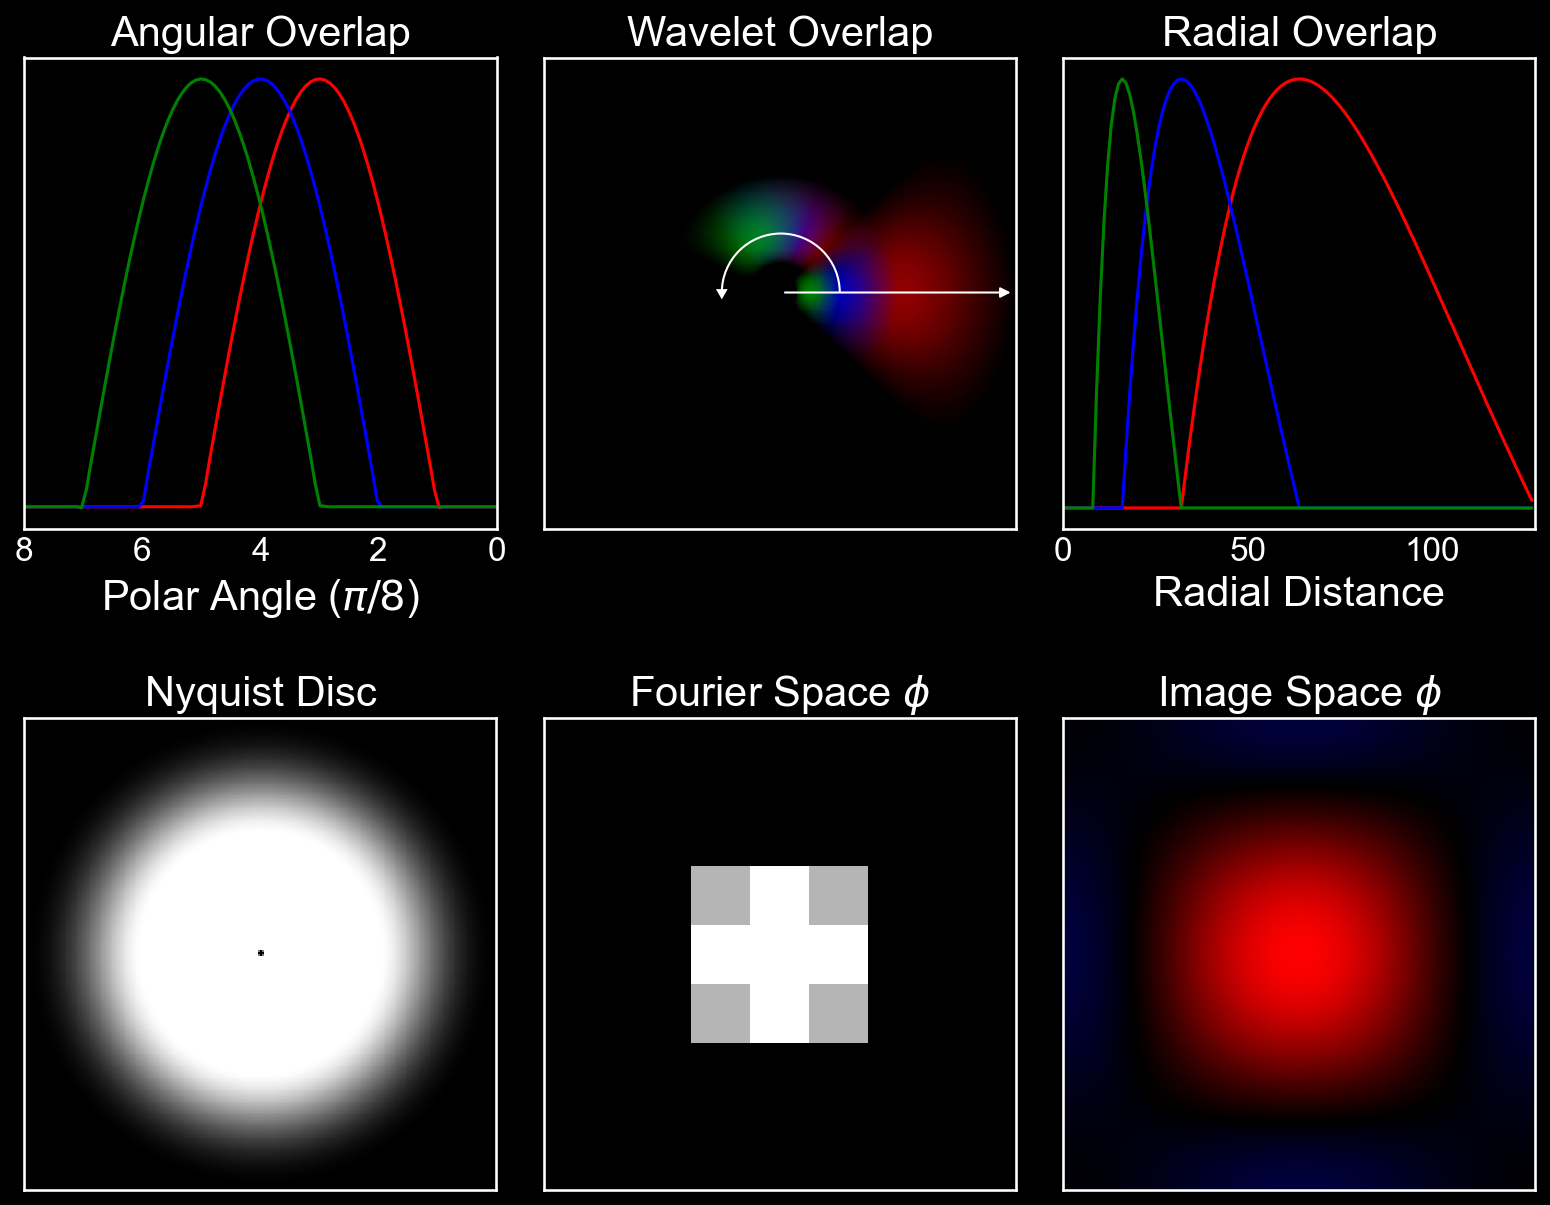

In [852]:
## Figure 1
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(13,10), dpi=150)

ax = fig.add_subplot(2,3,2)
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[jind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
ax.axes.set_title('Wavelet Overlap')

ax.annotate("",
            xy=(255, 128), xycoords='data',
            xytext=(128, 128), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3",
                            color='w'),
            )

drawCirc(ax,64,128,128,0,180,color_='w')

colormaps = [cmapred,cmapblue,cmapgreen]
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[lind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,3)
color_opt = ['red','blue','green']
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    plt.plot(np.fft.fftshift(data).T[128,128:],color=color_opt[jind])
    ax.axes.yaxis.set_ticks([])
    ax.set_xlim(0,128)
ax.axes.set_xlabel('Radial Distance')
ax.axes.set_title('Radial Overlap')

ax = fig.add_subplot(2,3,1)
color_opt = ['red','blue','green']
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    data = np.fft.fftshift(data)
    
    t = np.linspace(np.pi,0,100)
    r = 32
    xc = 128
    yc = 128
    x = r*np.cos(t) + xc
    y = r*np.sin(t) + yc
    zi_fink = map_coordinates(data, np.vstack((x,y)))
    plt.plot(t/np.pi*8,zi_fink,color=color_opt[lind])
    ax.set_xlim(8, 0)
    ax.axes.yaxis.set_ticks([])
ax.axes.set_xlabel('Polar Angle ($\pi/8$)')
ax.axes.set_title('Angular Overlap')

ax = fig.add_subplot(2,3,4)
total_im_energy = np.zeros((256,256))
for j in range(6):
    for l in range(16):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1].T
        total_im_energy += np.fft.fftshift(data)**2

ax.imshow(
    total_im_energy,
    vmin=0,
    #vmax=1,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal',
    alpha=1
)
ax.axes.set_title('Nyquist Disc')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,5)

data = filter_bank2D[filter_bank2D_phi_index[0]-1].T
scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])

j=5
ax.imshow(
    np.fft.fftshift(data),
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.set_title('Fourier Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])

ax = fig.add_subplot(2,3,6)
ax.imshow(
    np.real(np.fft.fftshift(fft2(data)).T),
    vmin=-scale,
    vmax=scale,
    origin='lower',
    interpolation='nearest',
    cmap=blue_red1,
    aspect='equal'
)
ax.axes.set_title('Image Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(np.abs(j+2)),128+2**(np.abs(j+2))])
ax.axes.set_ylim([128-2**(np.abs(j+2)),128+2**(np.abs(j+2))])

fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig('../figures/FinkletOrientDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 2

In [10]:
def subplotter(data,fig,subplotx,subploty,subplotindx,j):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    ax.imshow(
        np.fft.fftshift(data).T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
    ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])
    ax.text(0.14, 0.05, 'FS j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])
    ax = fig.add_subplot(subplotx,subploty,subplotindx+8)
    ax.imshow(
        np.real(np.fft.fftshift(fft2(data)).T),
        vmin=-scale,
        vmax=scale,
        origin='lower',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Re j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    ax = fig.add_subplot(subplotx,subploty,subplotindx+16)
    ax.imshow(
        np.imag(np.fft.fftshift(fft2(data)).T),
        origin='lower',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Im j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)
    return

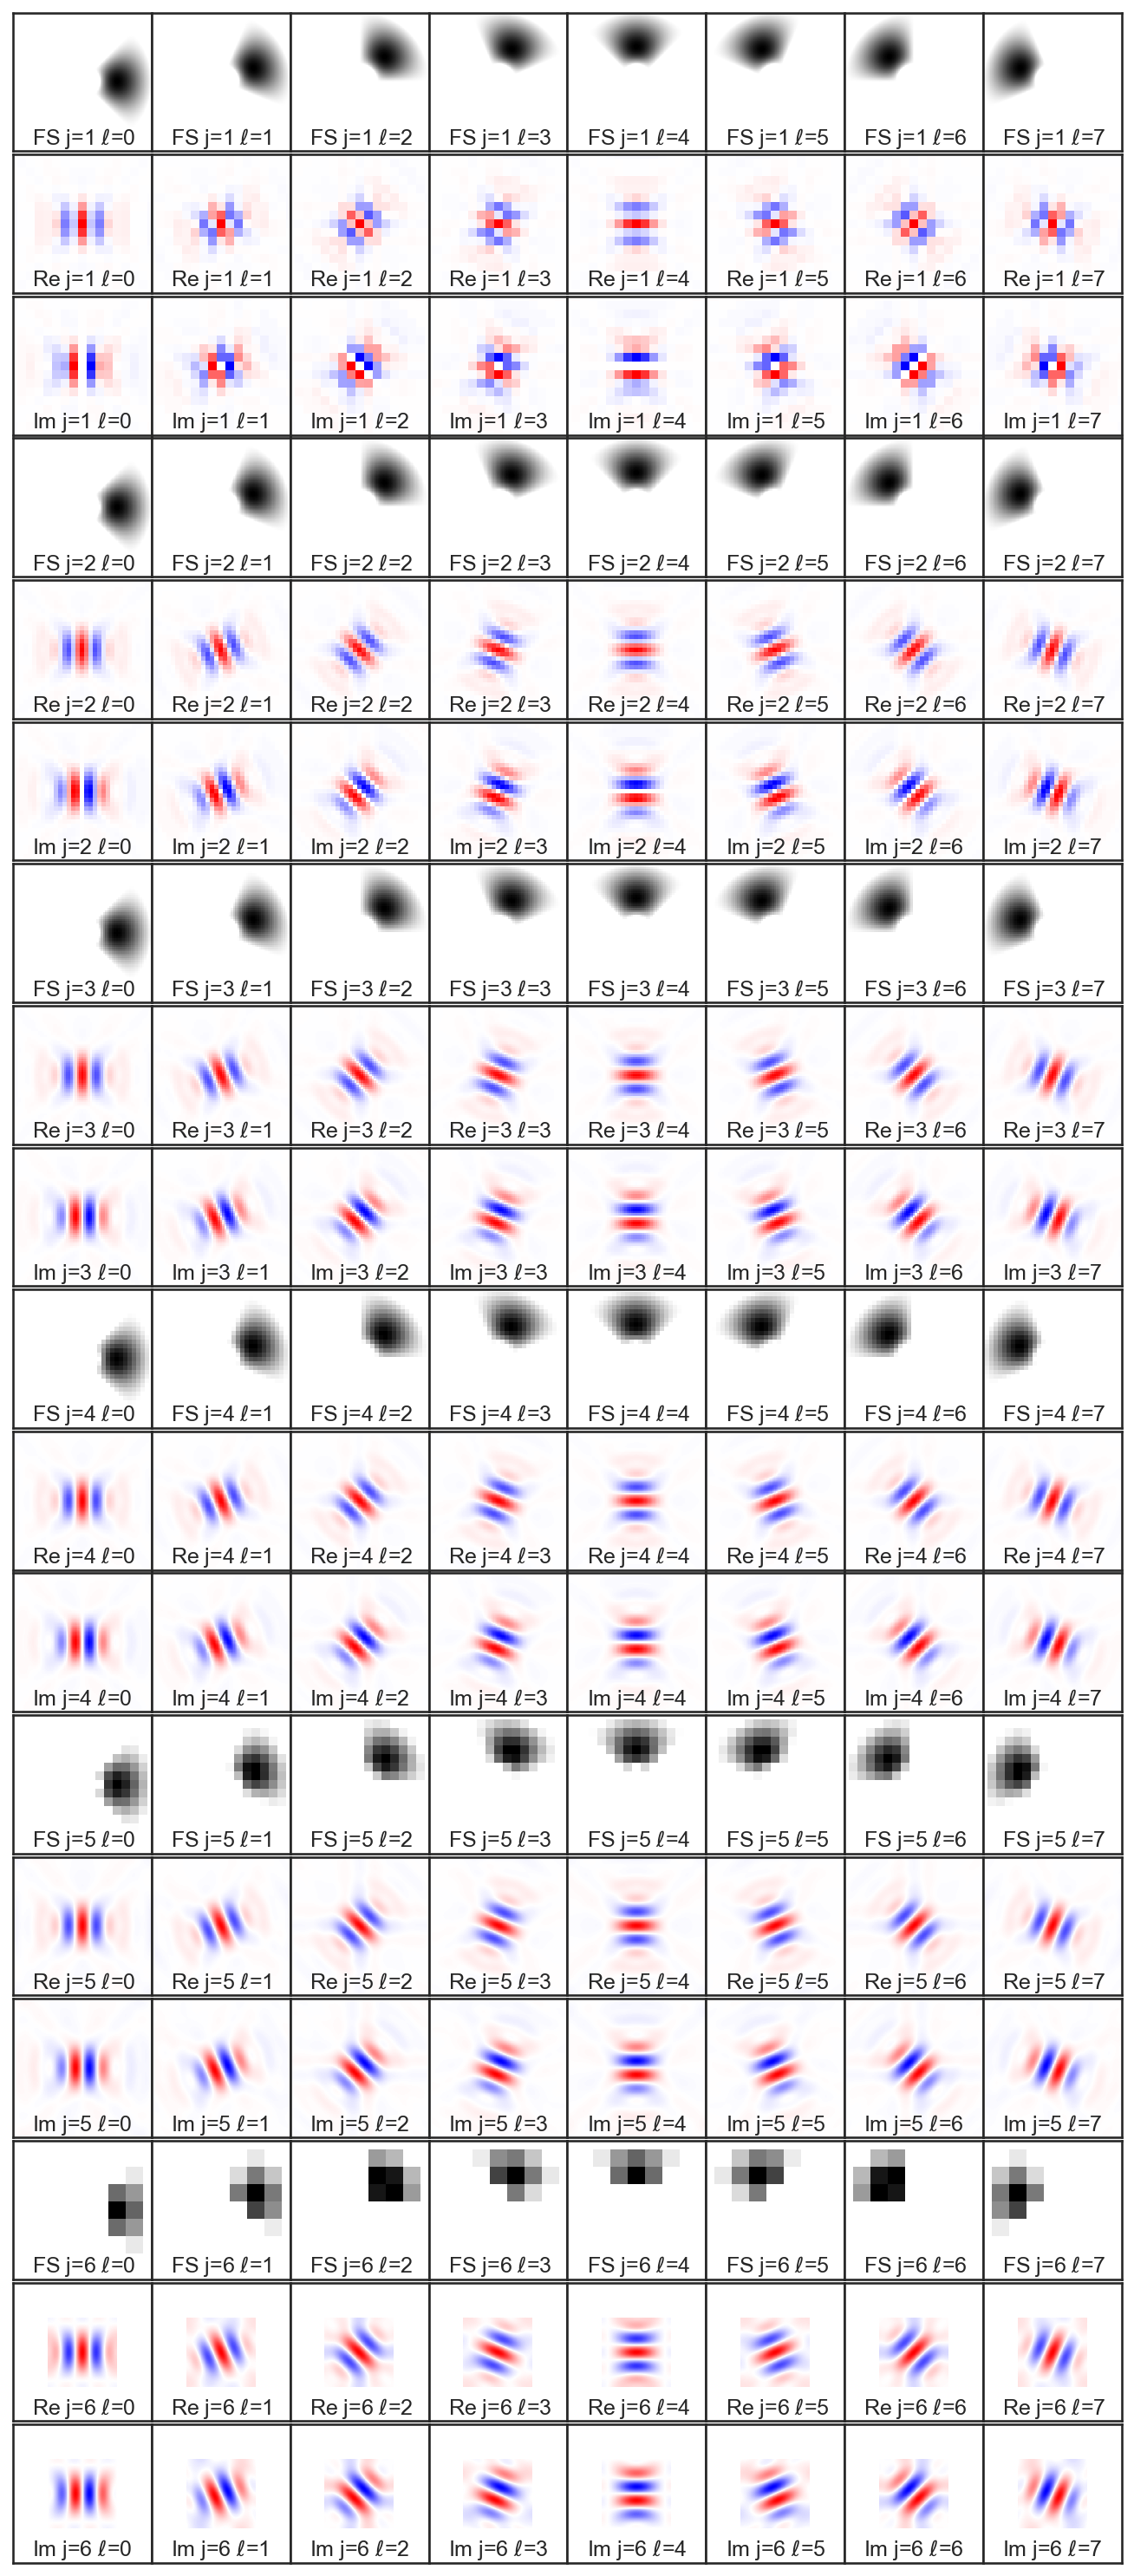

In [15]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(11,25.5), dpi=150)
for j in range(6):
    for l in range(8):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
        subplotter(data,fig,6*3,8,j*8*3+l+1,j)

fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('../figures/FinkletBank.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

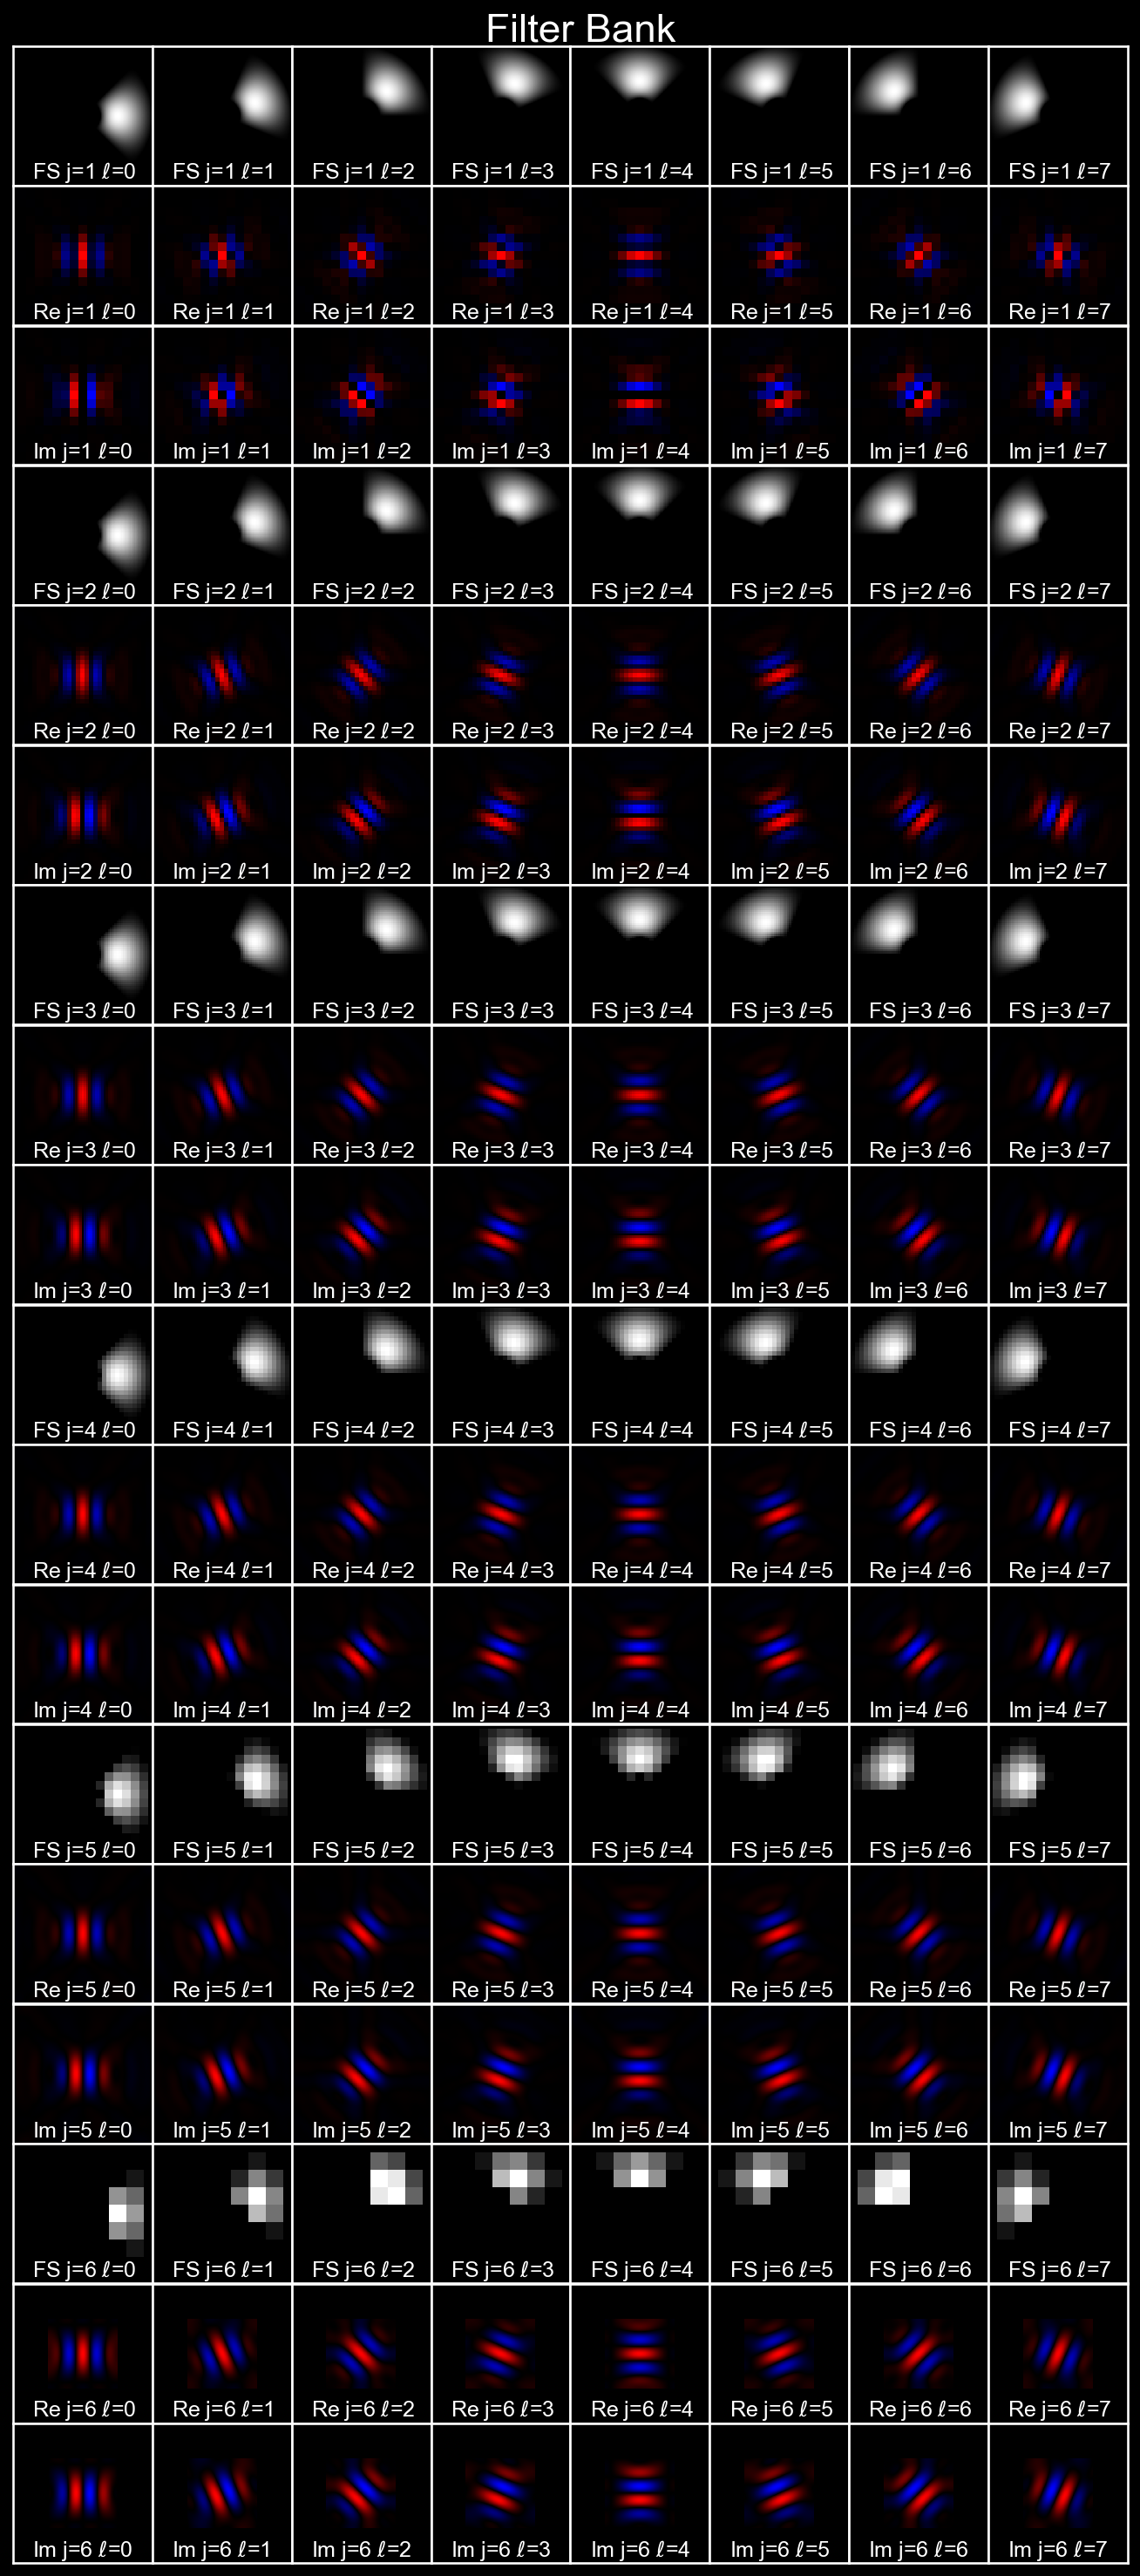

In [854]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')

def subplotter(data,fig,subplotx,subploty,subplotindx,j):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    ax.imshow(
        np.fft.fftshift(data).T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
    ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])
    ax.text(0.14, 0.05, 'FS j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])
    ax = fig.add_subplot(subplotx,subploty,subplotindx+8)
    ax.imshow(
        np.real(np.fft.fftshift(fft2(data)).T),
        vmin=-scale,
        vmax=scale,
        origin='lower',
        interpolation='nearest',
        cmap=blue_red1,
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Re j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    ax = fig.add_subplot(subplotx,subploty,subplotindx+16)
    ax.imshow(
        np.imag(np.fft.fftshift(fft2(data)).T),
        origin='lower',
        interpolation='nearest',
        cmap=blue_red1,
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Im j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)
    return

fig = plt.figure(figsize=(11,25.5), dpi=150)
for j in range(6):
    for l in range(8):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
        subplotter(data,fig,6*3,8,j*8*3+l+1,j)

plt.suptitle('Triglet Filter Bank',size=22,x=0.52,y=0.89)
fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('../figures/FinkletBankDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 3

In [79]:
import itertools
import sklearn

In [80]:
rod_corner = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/coeffs')
rod_corner_lab = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/labels')

In [81]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/labels')

In [82]:
rod_ex_images = hd5_open('../scratch_AKS/paper_data/images.h5','main/data')
rod_ex_curves = hd5_open('../scratch_AKS/paper_data/curves.h5','main/data')

In [71]:
def angle_plots(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[l],
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    #ax.axes.yaxis.set_ticks([])
    ax.set_ylabel('$\Delta$')
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    plt.vlines(l*180/8+90,0,361,'k','--',alpha=0.5)
    plt.vlines(l*180/8+180+90,0,361,'k','--',alpha=0.5)
    ax.set_xlim(0,361)
    return temp_mat[:,180]

In [72]:
def angle_plots_strip(index_data, data,l):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,180]

In [73]:
def curve_plots_strip(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,indx]

In [74]:
def curve_plots(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    #ax.axes.yaxis.set_ticks([])
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    ax.set_yticks([0,90,180,270,360])
    ax.set_yticklabels((0,0.25,0.5,0.75,1.0))
    ax.set_ylabel('$f_{bend}$')
    
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    
    if l==0:
        plt.hlines(0,0,361,'r','--',alpha=0.5)
        plt.hlines(90,0,361,'b','--',alpha=0.5)
        plt.hlines(360,0,361,'g','--',alpha=0.5)
    ax.set_xlim(0,361)
        
    return temp_mat[:,indx]

In [83]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta$')

series = np.zeros((8,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','b','g']


for l in range(8):
    series[l,:] = angle_plots_strip(rod_corner_lab[:,0:2],rod_corner,l)

ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
for i in range(3,8):
    ax.plot(series[i,:],color='grey',alpha=0.5)
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.set_xlabel('$\Sigma$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    series[l,:] = curve_plots(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,0)

l=0
temp_ind = 0
series = np.zeros((3,361))
for indx in [0,90,360]:
    series[temp_ind,:] = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','b','g']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)
plt.savefig('../figures/RotEquiv.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [75]:
def pwr_plots_strip(index_data,l,indx):
    temp_mat = np.zeros((361,361))
    indexes = index_data[:,0:2]
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = index_data[index,2]
    
    return temp_mat[:,indx]

In [85]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/labels')

In [87]:
temp.min()

0.007257086638291209

In [86]:
temp = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),0,360)
pwr_tmp = pwr_plots_strip(rod_curve_lab,0,360)
(temp.max()-temp.min())/temp.mean(), np.std(temp)/temp.mean(), (pwr_tmp.max()-pwr_tmp.min())/pwr_tmp.mean(), np.std(pwr_tmp)/np.mean(pwr_tmp)

(0.008863147265114715,
 0.0019506220059125484,
 0.00149034977933371,
 0.00032221735254916653)

In [647]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40_10.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40_10.h5','main/labels')

In [659]:
temp = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),0,360)
(temp.max()-temp.min())/temp.mean(), np.std(temp)/temp.mean(), (pwr_tmp.max()-pwr_tmp.min())/pwr_tmp.mean(), np.std(pwr_tmp)/np.mean(pwr_tmp)

(0.008863147265114715,
 0.0019506220059125484,
 0.00149034977933371,
 0.00032221735254916653)

In [639]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod.h5','main/labels')

In [660]:
temp = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),0,360)
(temp.max()-temp.min())/temp.mean(), np.std(temp)/temp.mean(), (pwr_tmp.max()-pwr_tmp.min())/pwr_tmp.mean(), np.std(pwr_tmp)/np.mean(pwr_tmp)

(0.008863147265114715,
 0.0019506220059125484,
 0.00149034977933371,
 0.00032221735254916653)

In [975]:
def curve_plots(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    ax.set_yticks([0,90,180,270,360])
    ax.set_yticklabels((0,0.25,0.5,0.75,1.0))
    ax.set_ylabel('$f_{bend}$')
    
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    
    if l==0:
        plt.hlines(0,0,361,'r','--',alpha=0.5)
        plt.hlines(90,0,361,'b','--',alpha=0.5)
        plt.hlines(360,0,361,'g','--',alpha=0.5)
    ax.set_xlim(0,361)
        
    return temp_mat[:,indx]

def angle_plots(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[l],
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.set_ylabel('$\Delta$')
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    plt.vlines(l*180/8+90,0,361,'w','--',alpha=0.5)
    plt.vlines(l*180/8+180+90,0,361,'w','--',alpha=0.5)
    ax.set_xlim(0,361)
    return temp_mat[:,180]

def angle_plots_strip(index_data, data,l):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,180]

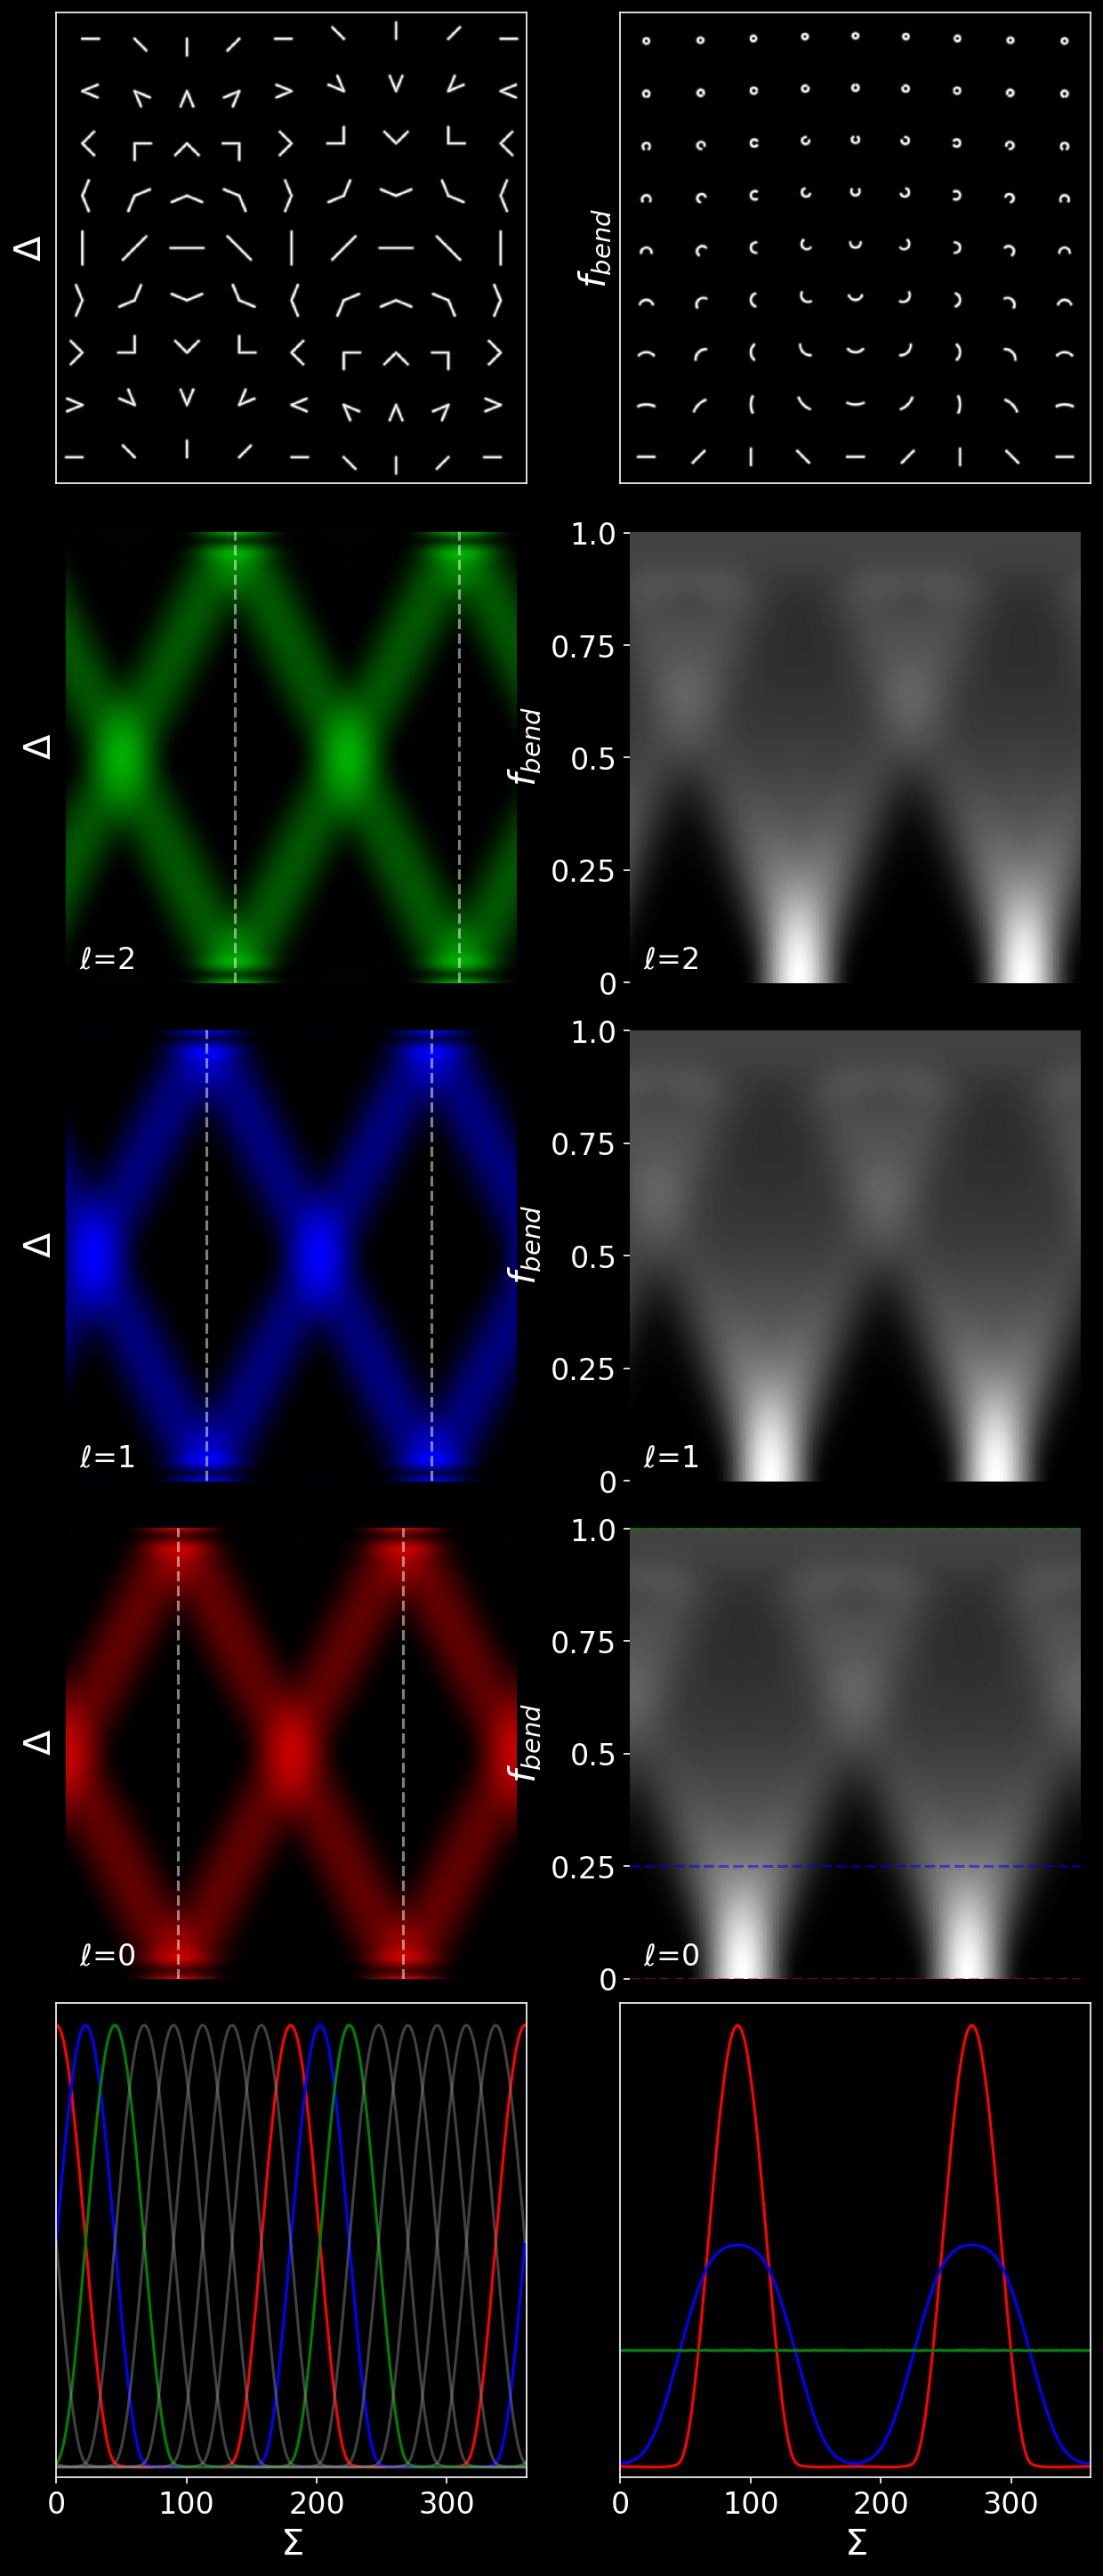

In [976]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta$')

series = np.zeros((8,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','b','g']
for l in range(8):
    series[l,:] = angle_plots_strip(rod_corner_lab[:,0:2],rod_corner,l)

ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
for i in range(3,8):
    ax.plot(series[i,:],color='grey',alpha=0.5)
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.set_xlabel('$\Sigma$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    series[l,:] = curve_plots(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,0)

l=0
temp_ind = 0
series = np.zeros((3,361))
for indx in [0,90,360]:
    series[temp_ind,:] = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','b','g']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)
plt.savefig('../figures/RotEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [86]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40_10.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40_10.h5','main/labels')

In [87]:
def curve_plots(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    ax.set_yticks([0,90,180,270,360])
    ax.set_yticklabels((0,0.25,0.5,0.75,1.0))
    ax.set_ylabel('$f_{bend}$')
    
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    
    if l==0:
        plt.hlines(0,0,361,'r','--',alpha=0.5)
        plt.hlines(90,0,361,'b','--',alpha=0.5)
        plt.hlines(360,0,361,'g','--',alpha=0.5)
    ax.set_xlim(0,361)
        
    return temp_mat[:,indx]

def angle_plots(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[l],
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.set_ylabel('$\Delta$')
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    plt.vlines(l*180/8+90,0,361,'w','--',alpha=0.5)
    plt.vlines(l*180/8+180+90,0,361,'w','--',alpha=0.5)
    ax.set_xlim(0,361)
    return temp_mat[:,180]

def angle_plots_strip(index_data, data,l):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,180]

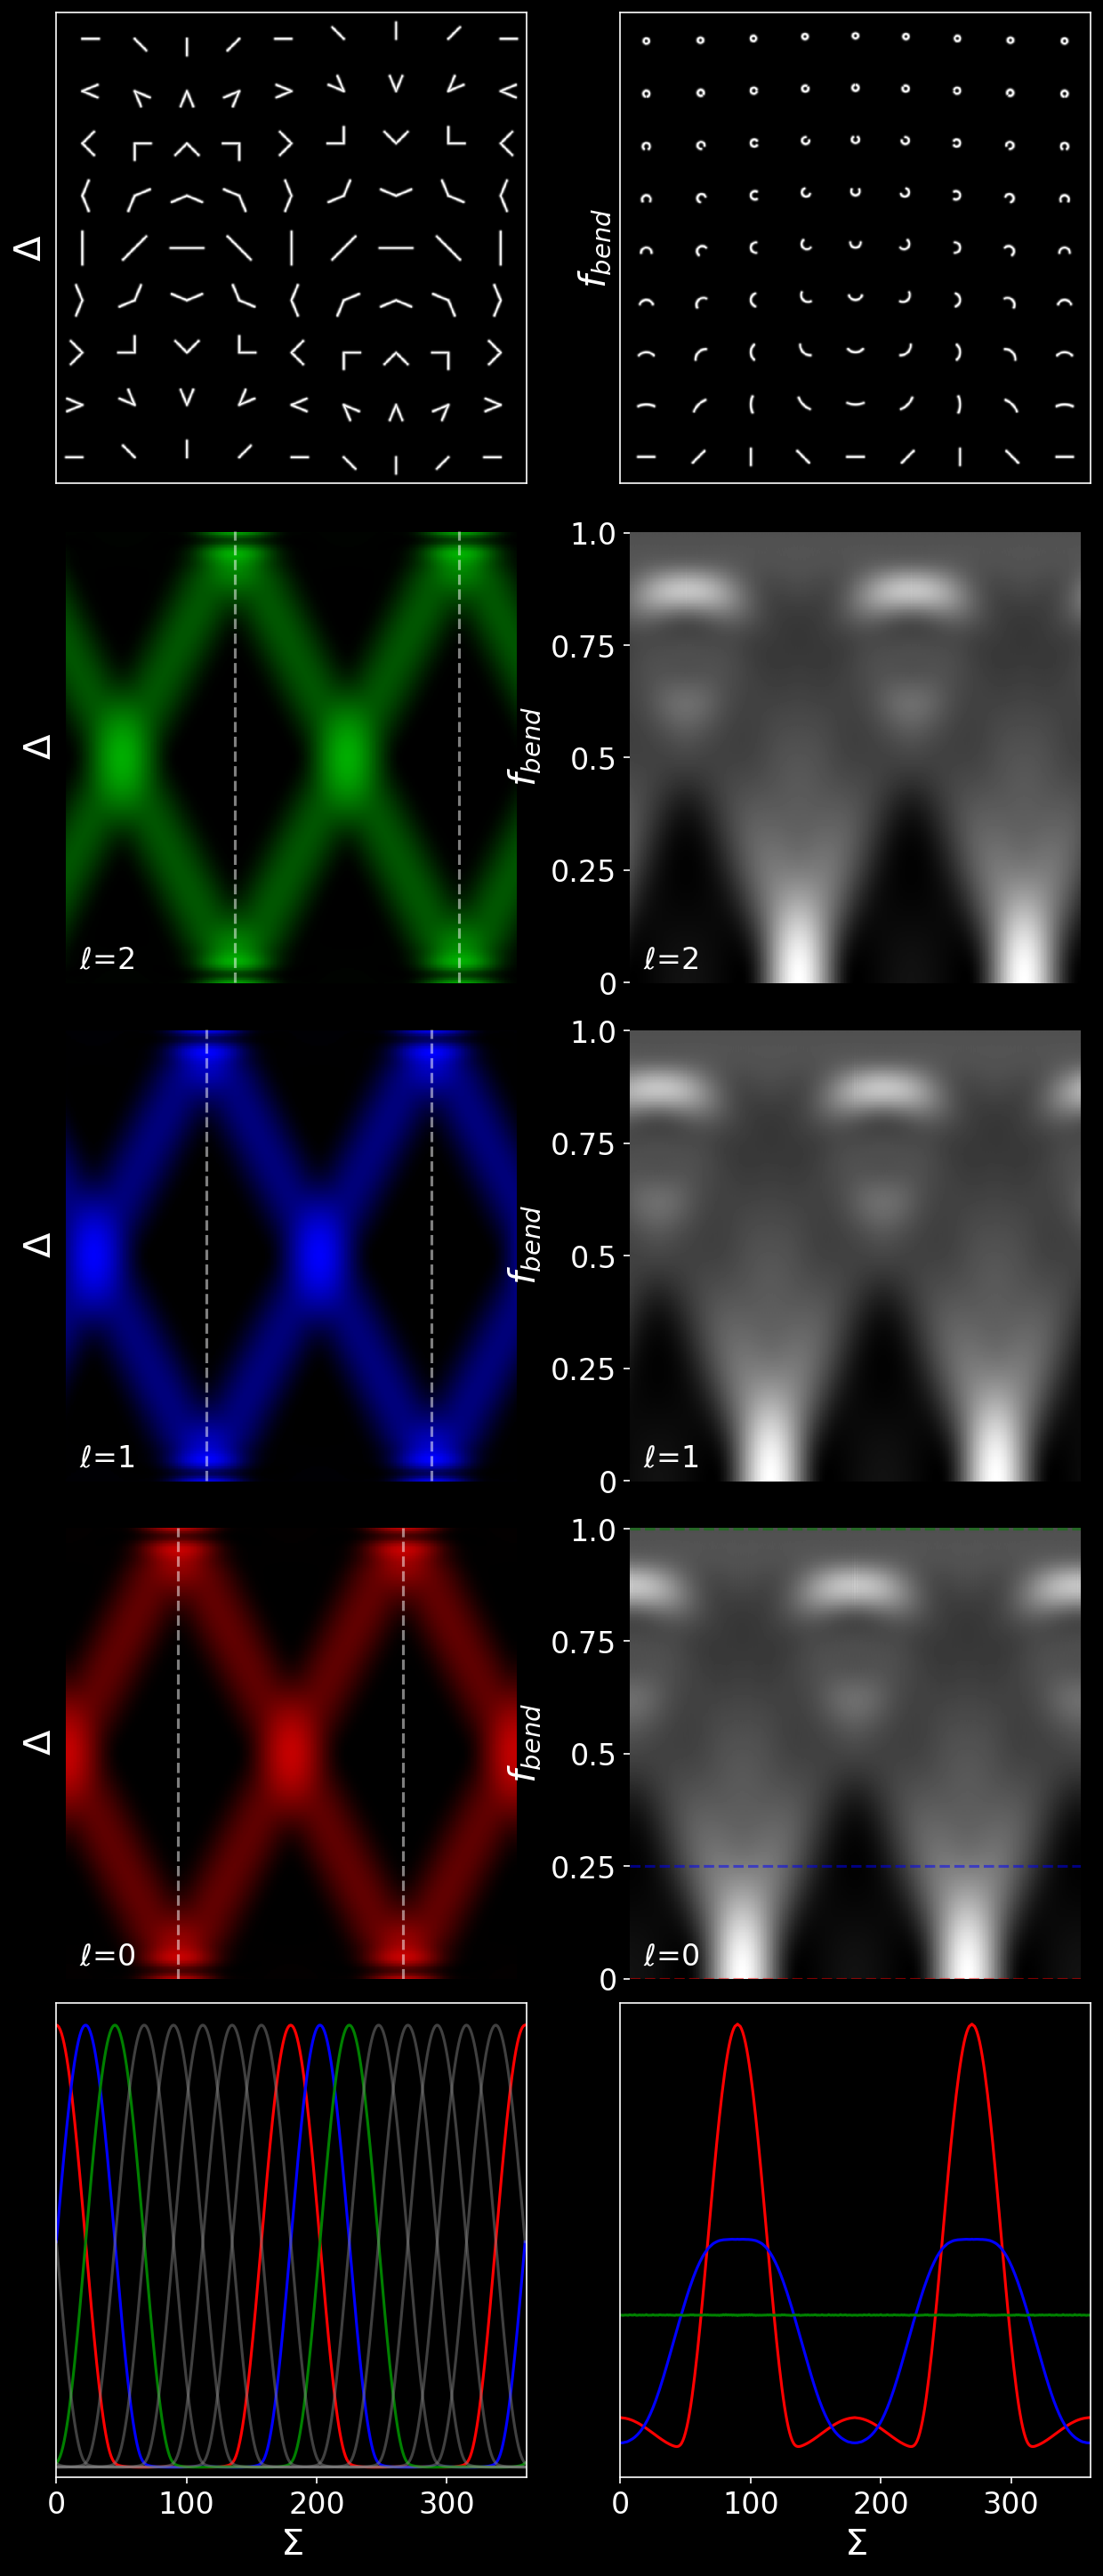

In [88]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta$')

series = np.zeros((8,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','b','g']
for l in range(8):
    series[l,:] = angle_plots_strip(rod_corner_lab[:,0:2],rod_corner,l)

ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
for i in range(3,8):
    ax.plot(series[i,:],color='grey',alpha=0.5)
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.set_xlabel('$\Sigma$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    series[l,:] = curve_plots(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,0)

l=0
temp_ind = 0
series = np.zeros((3,361))
for indx in [0,90,360]:
    series[temp_ind,:] = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','b','g']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)
#plt.savefig('../figures/RotEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

Figure 4

In [936]:
disc_data = hd5_open('../scratch_AKS/paper_data/disc_data_log.h5','main/coeffs')
disc_data_lab = hd5_open('../scratch_AKS/paper_data/disc_data_log.h5','main/labels')

In [937]:
indexes = copy.deepcopy(disc_data_lab)
list_scales = np.unique(indexes[:,0])
indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]

In [938]:
def radial_plots(fig,index_data, data, subplotx,subploty,subplotindx,j,color_set):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = copy.deepcopy(index_data)
    list_scales = np.unique(indexes[:,0])
    indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
    list_psfs = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_psfs==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,1+j-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    psfs_list = [np.argmin(np.abs(list_psfs-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    
    if np.logical_or(j==6,j==7):
        ax.set_xticks(lines_list)
        ax.set_xticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_xlabel('Radius')
        
    if np.any([j==2,j==4,j==6]):
        ax.set_yticks(psfs_list)
        ax.set_yticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_ylabel('FWHM')
    
    plt.vlines(lines_list[j-2],0,361,'r','--',alpha=1)
    if psfs_list[j-2] < 360:
        plt.hlines(psfs_list[j-2],0,361,'r','--',alpha=1)
    
    plt.hlines(psfs_list[1],0,361,color_set,'--',alpha=1)
    
    if j <5:
        ax.text(0.87, 0.89, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
    if j>4:
        ax.text(0.03, 0.03, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
        

    ax.set_xlim(0,361)
        
    return temp_mat[:,psfs_list[1]]

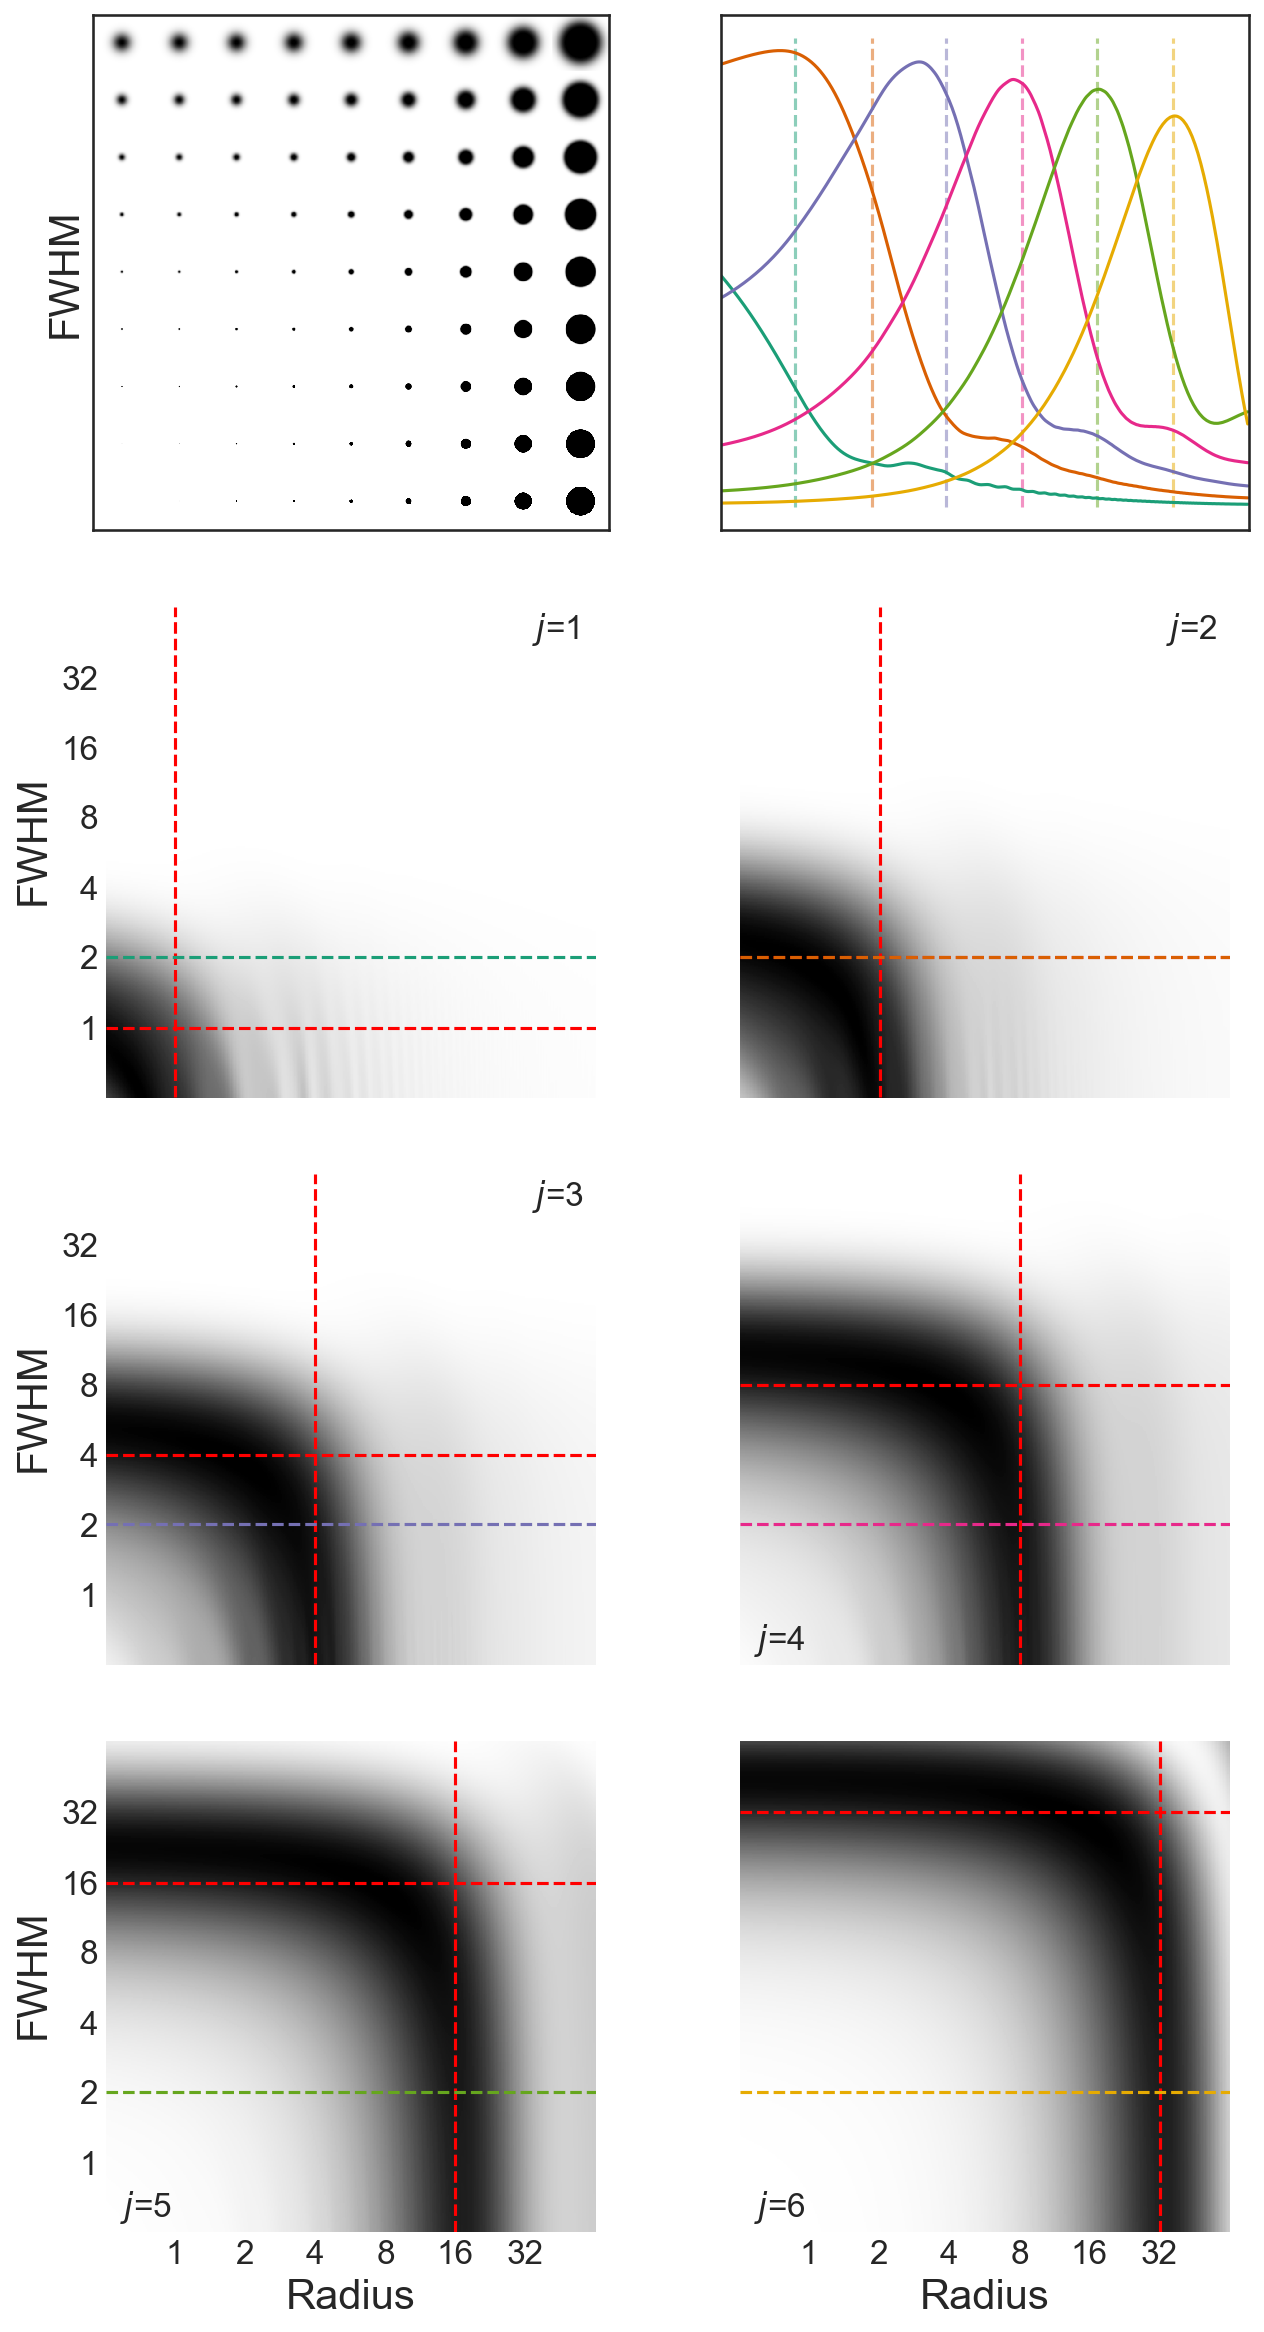

In [939]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(10,19.2), dpi=150)

ax = fig.add_subplot(4,2,1)
ax.imshow(
    disc_ex_images,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('FWHM')

series = np.zeros((6,361))
cmap = mpl.cm.get_cmap('Dark2')
for j in range(2,8):
    series[j-2,:] = radial_plots(fig,disc_data_lab[:,0:2],disc_data,4,2,2+j-1,j,cmap(j-2))

ax = fig.add_subplot(4,2,2)
for i in range(0,6):
    ax.plot(series[i,:],color=cmap(i))
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
i=0
for x in lines_list:
    plt.vlines(x,0,.06,cmap(i),'--',alpha=0.5)
    i+=1
    
fig.subplots_adjust(hspace=0.1,wspace=0.2)
plt.savefig('../figures/ScaleEquiv.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [934]:
def radial_plots(fig,index_data, data, subplotx,subploty,subplotindx,j,color_set):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = copy.deepcopy(index_data)
    list_scales = np.unique(indexes[:,0])
    indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
    list_psfs = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_psfs==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,1+j-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    psfs_list = [np.argmin(np.abs(list_psfs-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    
    if np.logical_or(j==6,j==7):
        ax.set_xticks(lines_list)
        ax.set_xticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_xlabel('Radius')
        
    if np.any([j==2,j==4,j==6]):
        ax.set_yticks(psfs_list)
        ax.set_yticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_ylabel('FWHM')
    
    plt.vlines(lines_list[j-2],0,361,'r','--',alpha=1)
    if psfs_list[j-2] < 360:
        plt.hlines(psfs_list[j-2],0,361,'r','--',alpha=1)
    
    plt.hlines(psfs_list[1],0,361,color_set,'--',alpha=1)
    
    if j <5:
        ax.text(0.87, 0.89, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
    if j>4:
        ax.text(0.03, 0.03, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
        

    ax.set_xlim(0,361)
        
    return temp_mat[:,psfs_list[1]]

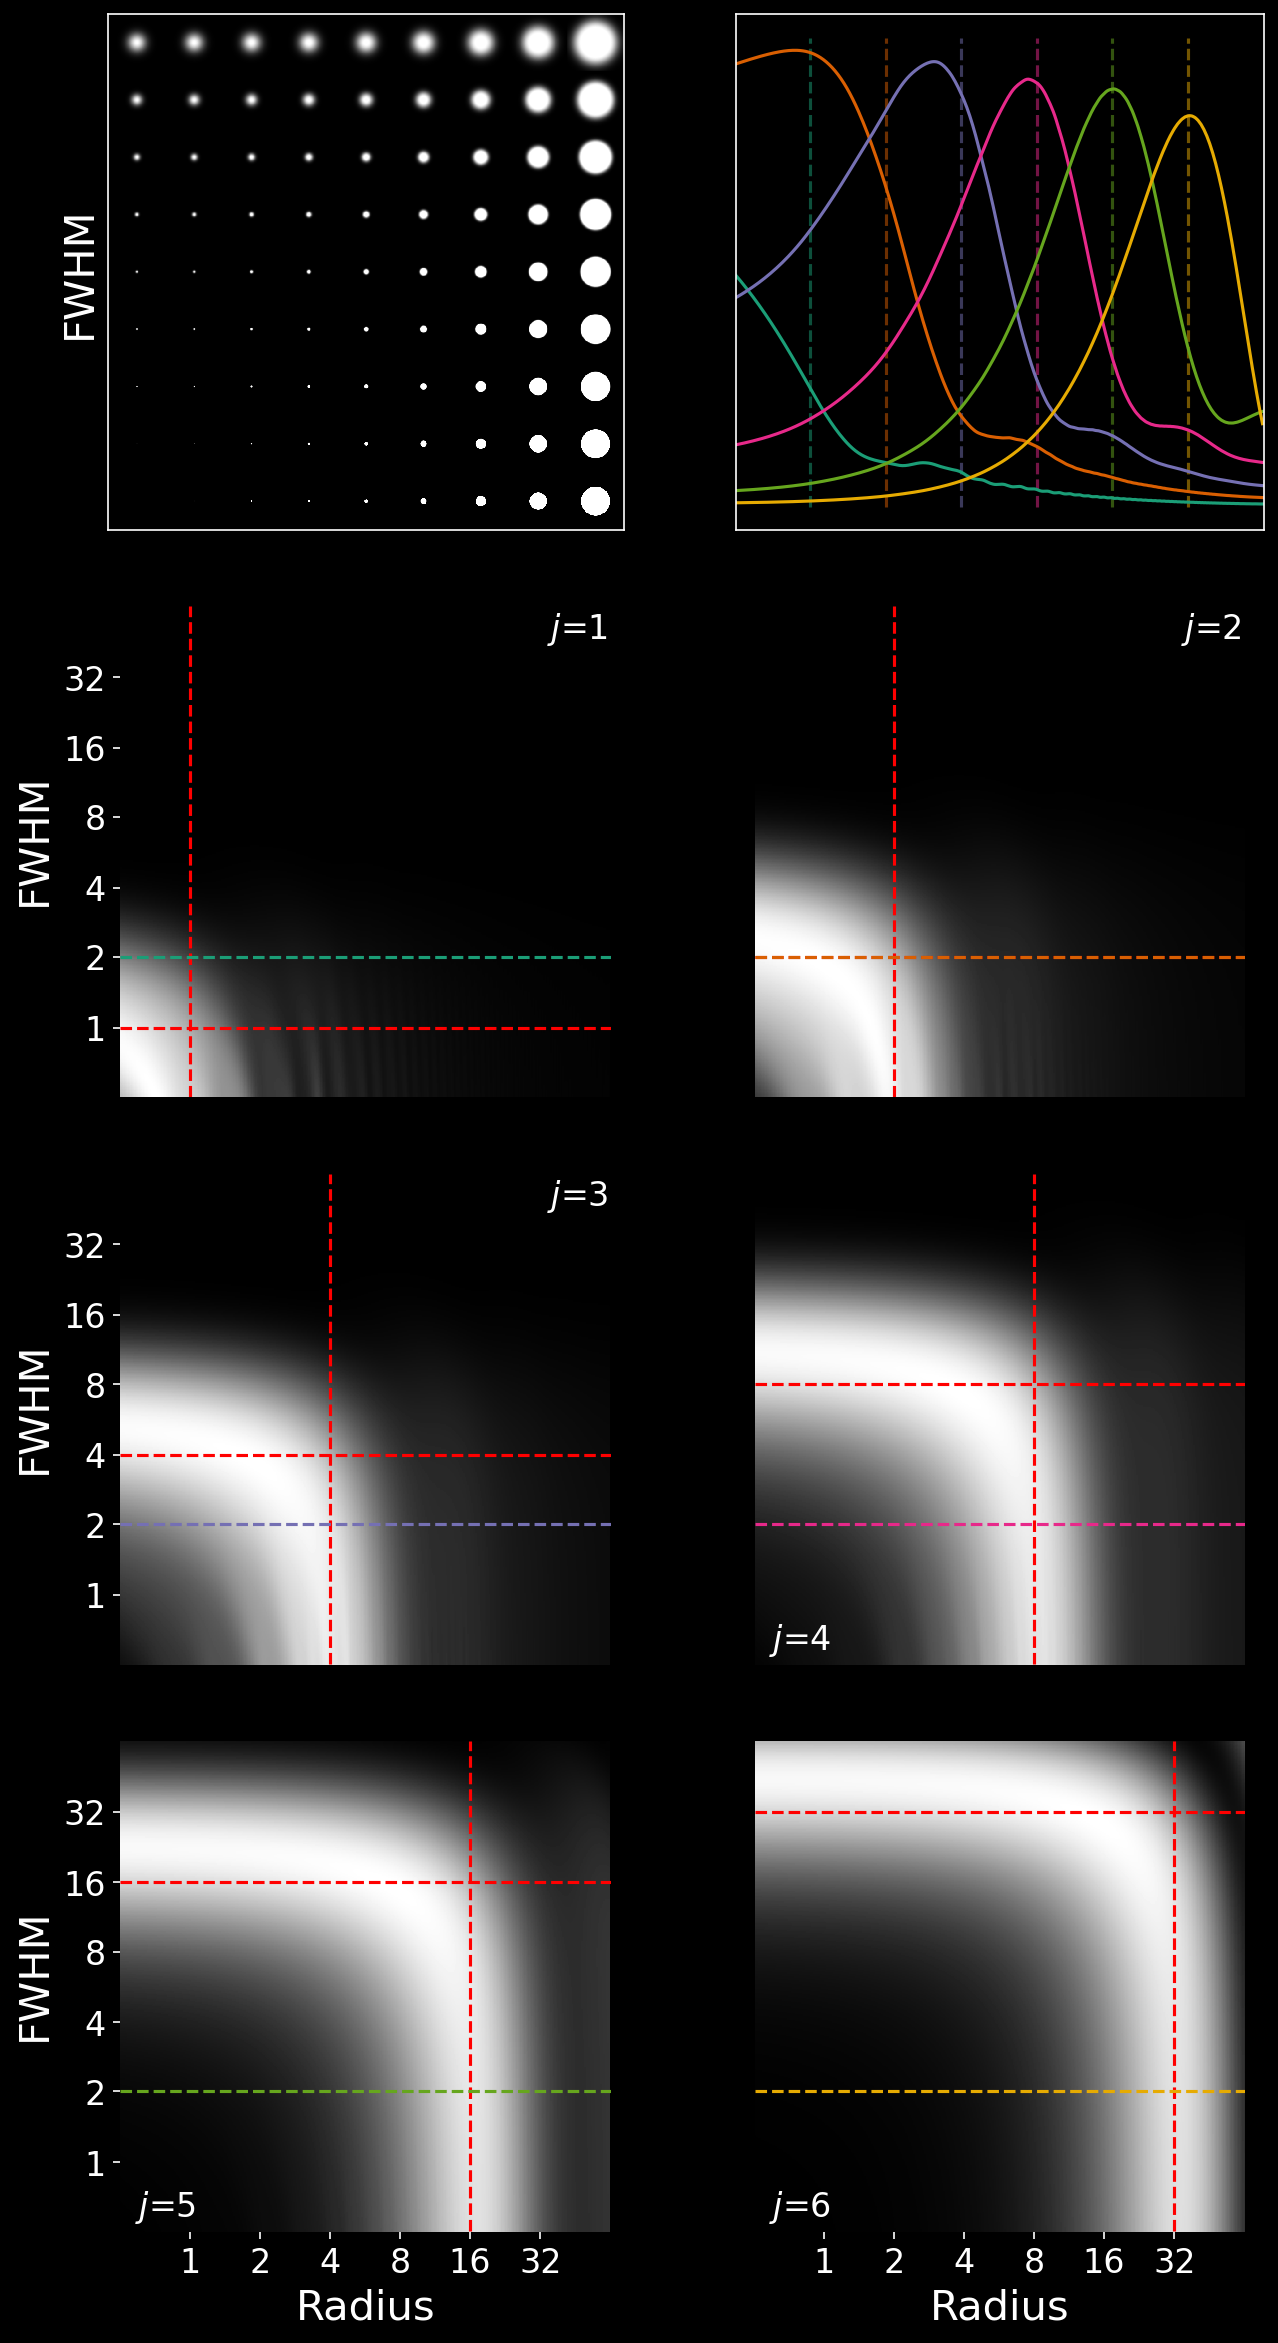

In [935]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,19.2), dpi=150)

ax = fig.add_subplot(4,2,1)
ax.imshow(
    disc_ex_images,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('FWHM')

series = np.zeros((6,361))
cmap = mpl.cm.get_cmap('Dark2')
for j in range(2,8):
    series[j-2,:] = radial_plots(fig,disc_data_lab[:,0:2],disc_data,4,2,2+j-1,j,cmap(j-2))

ax = fig.add_subplot(4,2,2)
for i in range(0,6):
    ax.plot(series[i,:],color=cmap(i))
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
i=0
for x in lines_list:
    plt.vlines(x,0,.06,cmap(i),'--',alpha=0.5)
    i+=1
    
fig.subplots_adjust(hspace=0.1,wspace=0.2)
plt.savefig('../figures/ScaleEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [977]:
def radial_plots(fig,index_data, data, subplotx,subploty,subplotindx,j,color_set):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = copy.deepcopy(index_data)
    list_scales = np.unique(indexes[:,0])
    indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
    list_psfs = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_psfs==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,1+j-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    psfs_list = [np.argmin(np.abs(list_psfs-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    
    if np.logical_or(j==6,j==7):
        ax.set_xticks(lines_list)
        ax.set_xticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_xlabel('Radius')
        
    if np.any([j==2,j==4,j==6]):
        ax.set_yticks(psfs_list)
        ax.set_yticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_ylabel('FWHM')
    
    plt.vlines(lines_list[j-2],0,361,'r','--',alpha=1)
    if psfs_list[j-2] < 360:
        plt.hlines(psfs_list[j-2],0,361,'r','--',alpha=1)
    
    plt.hlines(psfs_list[1],0,361,color_set,'--',alpha=1)
    
    if j <5:
        ax.text(0.87, 0.89, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
    if j>4:
        ax.text(0.03, 0.03, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
        

    ax.set_xlim(0,361)
        
    return temp_mat[:,0]

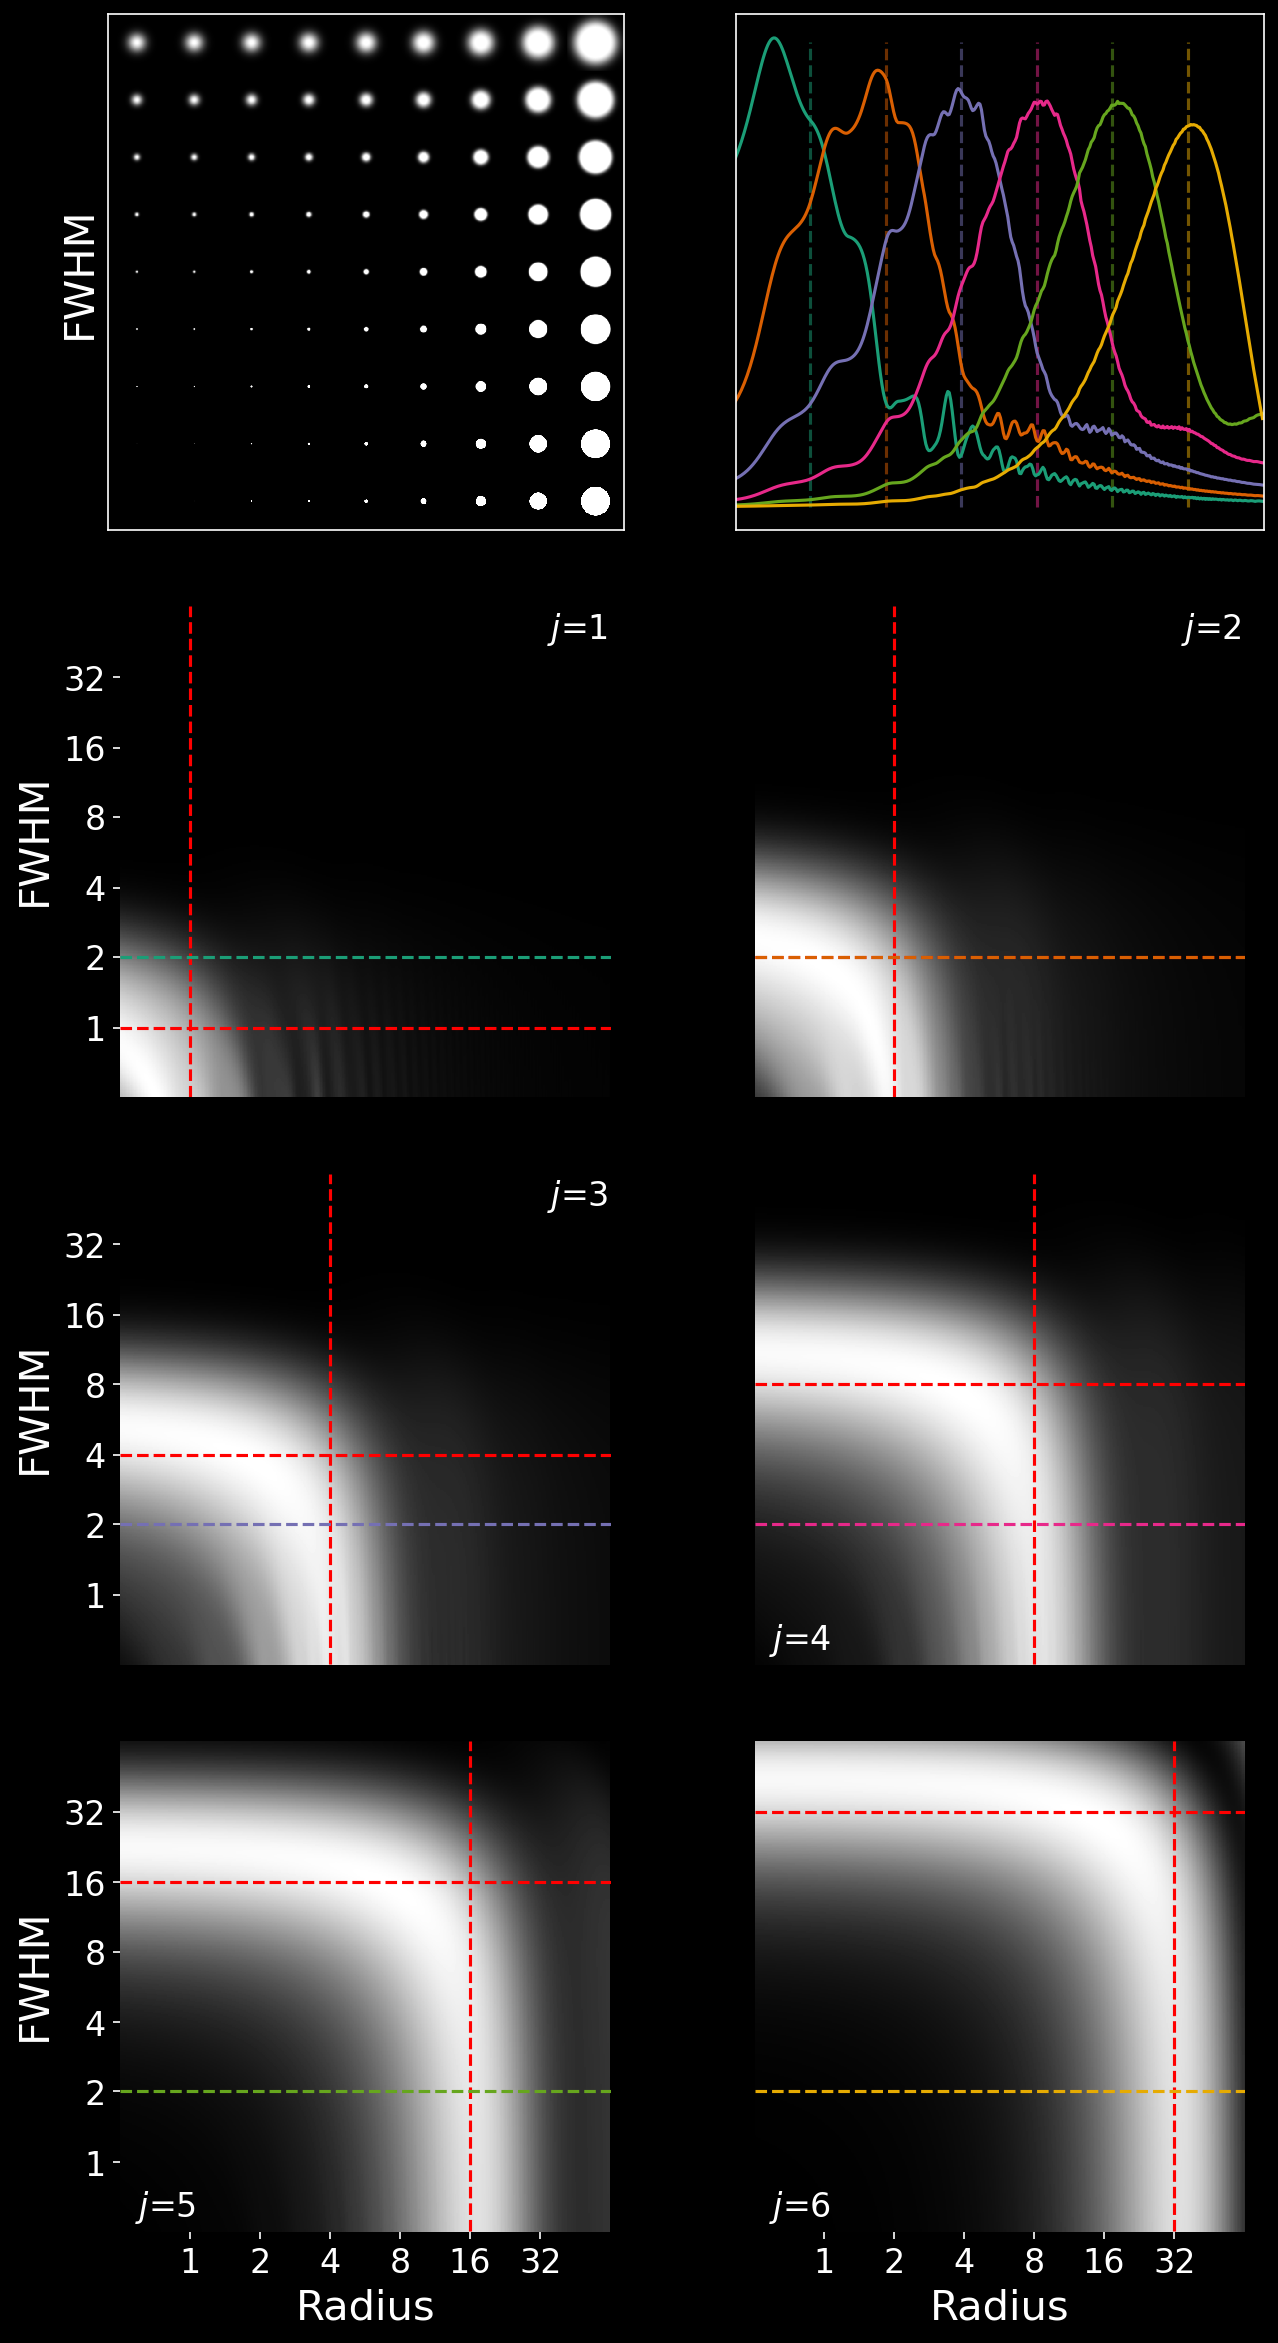

In [978]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,19.2), dpi=150)

ax = fig.add_subplot(4,2,1)
ax.imshow(
    disc_ex_images,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('FWHM')

series = np.zeros((6,361))
cmap = mpl.cm.get_cmap('Dark2')
for j in range(2,8):
    series[j-2,:] = radial_plots(fig,disc_data_lab[:,0:2],disc_data,4,2,2+j-1,j,cmap(j-2))

ax = fig.add_subplot(4,2,2)
for i in range(0,6):
    ax.plot(series[i,:],color=cmap(i))
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
i=0
for x in lines_list:
    plt.vlines(x,0,.06,cmap(i),'--',alpha=0.5)
    i+=1
    
fig.subplots_adjust(hspace=0.1,wspace=0.2)
#plt.savefig('../figures/ScaleEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Stablity plot

In [53]:
mnist_DHC_out_angles = hd5_open('../from_cannon/2021_01_20/mnist_DHC_test_angles.h5','main/data')

In [49]:
mnist_train_y = hd5_open('../scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/data/mnist_test_y.h5','main/data')

mnist_DHC_out_rotpi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rotpi_3.h5','main/data')
mnist_DHC_out_rotpi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rotpi_3_test.h5','main/data')

mnist_DHC_out_rot2pi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot2pi_3.h5','main/data')
mnist_DHC_out_rot2pi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot2pi_3_test.h5','main/data')

mnist_DHC_out_rot3pi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot3pi_3.h5','main/data')
mnist_DHC_out_rot3pi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot3pi_3_test.h5','main/data')

mnist_DHC_out_stack = np.vstack((mnist_DHC_out_rotpi_3,mnist_DHC_out_rot2pi_3,mnist_DHC_out_rot3pi_3))
mnist_DHC_out_stack_test = np.vstack((mnist_DHC_out_rotpi_3_test,mnist_DHC_out_rot2pi_3_test,mnist_DHC_out_rot3pi_3_test))

mnist_DHC_out_stack_train_y = np.hstack((mnist_train_y,mnist_train_y,mnist_train_y))
mnist_DHC_out_stack_test_y = np.hstack((mnist_test_y,mnist_test_y,mnist_test_y))

In [50]:
def prec_LDA(lda,X_test,y_test):
    y_pred = lda.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    return prec

def DHC_iso(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [51]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso(mnist_DHC_out_stack,6,8), mnist_DHC_out_stack_train_y)

LinearDiscriminantAnalysis(n_components=9)

In [54]:
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso(mnist_DHC_out_angles[i::100,:],6,8),mnist_test_y))

In [55]:
hf = h5py.File('../scratch_AKS/data/prec_mnist_angles_3.h5', 'w')
hf.create_dataset('data', data=prec_mnist_angles)
hf.close()

In [56]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(mnist_DHC_out_stack, mnist_DHC_out_stack_train_y)

prec_mnist_angles_noiso = []
for i in range(100):
    prec_mnist_angles_noiso.append(prec_LDA(lda,mnist_DHC_out_angles[i::100,:],mnist_test_y))

In [57]:
hf = h5py.File('../scratch_AKS/data/prec_mnist_angles_noiso_3.h5', 'w')
hf.create_dataset('data', data=prec_mnist_angles_noiso)
hf.close()

In [6]:
prec_mnist_angles = hd5_open('../scratch_AKS/data/prec_mnist_angles.h5','data')
prec_mnist_angles_noiso = hd5_open('../scratch_AKS/data/prec_mnist_angles_noiso.h5','data')

In [63]:
test_angles = hd5_open('../scratch_AKS/data/angles_listjl.h5','main/test_angles')
train_angles = hd5_open('../scratch_AKS/data/angles_listjl.h5','main/train_angles')

In [64]:
train_angles = train_angles[1:4]

In [65]:
train_angles

array([1.04719755, 2.0943951 , 3.14159265])

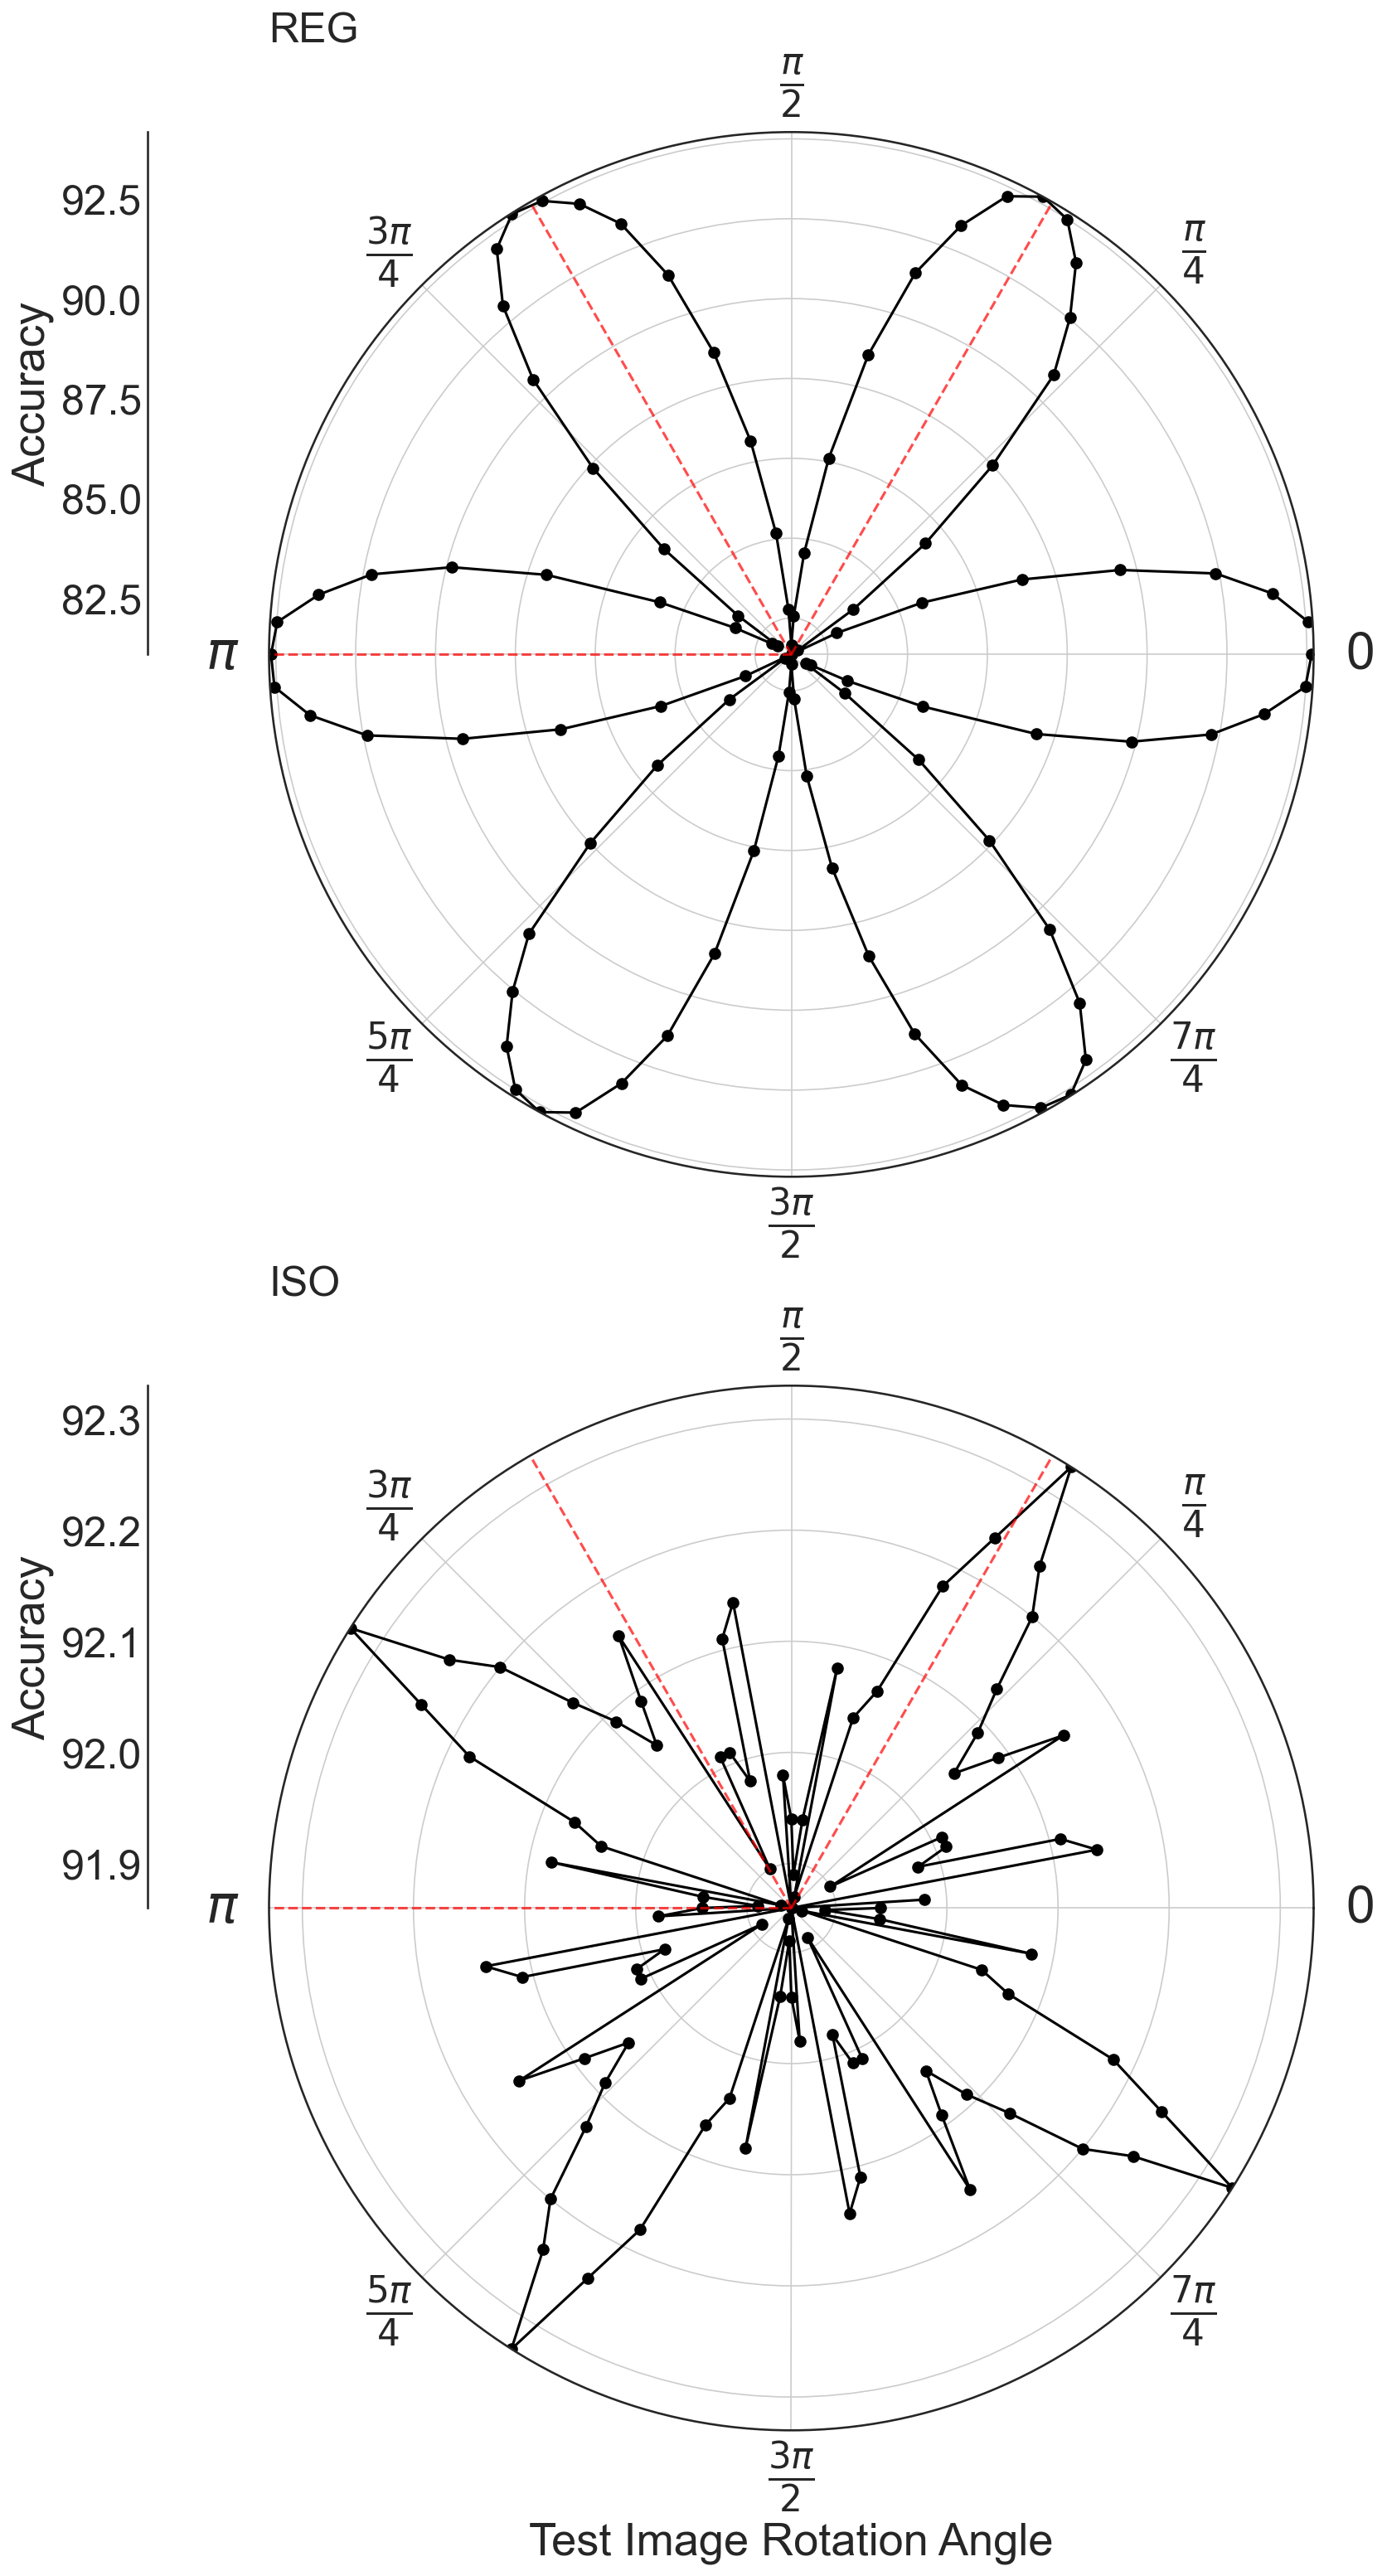

In [66]:
##
from matplotlib import transforms

mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = 24
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 26
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(12,24),dpi=150)
ax = fig.add_subplot(211,projection='polar') 
ax.plot(test_angles,100*np.array(prec_mnist_angles_noiso), linestyle='-', marker='o',color='k')
plt.title('REG',loc='left')
ax.set_ylim(100*np.array(prec_mnist_angles_noiso).min(),100*np.array(prec_mnist_angles_noiso).max())
for x in train_angles:
    plt.axvline(x=x,linestyle='--',color='r',alpha=0.7)
    
ax.tick_params(pad=20)
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL, size=30)
ax.set_yticklabels([])

box=ax.get_position()
axl=fig.add_axes([box.xmin/2, #put it half way between the edge of the 1st subplot and the left edge of the figure
                  0.5*(box.ymin+box.ymax), #put the origin at the same height of the origin of the polar plots
                  box.width/40, #Doesn't really matter, we will set everything invisible, except the y axis
                  box.height*0.5])
axl.spines['top'].set_visible(False)
axl.spines['right'].set_visible(False)
axl.spines['bottom'].set_visible(False)
axl.yaxis.set_ticks_position('both')
axl.xaxis.set_ticks_position('none')
axl.set_xticklabels([])
axl.set_ylim(100*np.array(prec_mnist_angles_noiso).min(),100*np.array(prec_mnist_angles_noiso).max())
axl.set_ylabel('Accuracy', rotation=90)

ax = fig.add_subplot(212,projection='polar') 
ax.plot(test_angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o',color='k')
plt.xlabel('Test Image Rotation Angle')
plt.title('ISO',loc='left')
ax.set_ylim(100*np.array(prec_mnist_angles).min(),100*np.array(prec_mnist_angles).max())
for x in train_angles:
    plt.axvline(x=x,linestyle='--',color='r',alpha=0.7)
    
ax.tick_params(pad=20)
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL, size=30)
ax.set_yticklabels([])

box=ax.get_position()
axl=fig.add_axes([box.xmin/2, #put it half way between the edge of the 1st subplot and the left edge of the figure
                  0.5*(box.ymin+box.ymax), #put the origin at the same height of the origin of the polar plots
                  box.width/40, #Doesn't really matter, we will set everything invisible, except the y axis
                  box.height*0.5])
axl.spines['top'].set_visible(False)
axl.spines['right'].set_visible(False)
axl.spines['bottom'].set_visible(False)
axl.yaxis.set_ticks_position('both')
axl.xaxis.set_ticks_position('none')
axl.set_xticklabels([])
axl.set_ylim(100*np.array(prec_mnist_angles).min(),100*np.array(prec_mnist_angles).max())
axl.set_ylabel('Accuracy', rotation=90)

fig.subplots_adjust(hspace=0.2,wspace=0)
plt.savefig('../figures/RotAngleStability.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [42]:
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(92.05920000000002, 0.11808200540302453)

In [43]:
np.mean(100*np.array(prec_mnist_angles_noiso)), np.std(100*np.array(prec_mnist_angles_noiso))

(88.52, 4.584877970022756)

In [58]:
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(92.06070000000001, 0.12259082347386373)

In [59]:
np.mean(100*np.array(prec_mnist_angles_noiso)), np.std(100*np.array(prec_mnist_angles_noiso))

(88.51810000000002, 4.58219154881155)

Equivariance Plot

In [330]:
std_class = hd5_open('../from_cannon/2021_03_09/equiv_workup_L3.h5','std_class')
std_class_both = hd5_open('../from_cannon/2021_03_09/equiv_workup_L3.h5','std_class_both')
std_class_ref = hd5_open('../from_cannon/2021_03_09/equiv_workup_L3.h5','std_class_ref')
equiv_std = hd5_open('../from_cannon/2021_03_09/equiv_workup_L3.h5','equiv_std_full')

In [354]:
L_list = np.array([3,4,5,6,7,8])
len_L_list = L_list.shape[0]
std_class_L = np.zeros((len_L_list,std_class.shape[0],std_class.shape[1],std_class.shape[2]))
std_class_both_L = np.zeros((len_L_list,std_class_both.shape[0]-1,std_class_both.shape[1],std_class_both.shape[2]))
std_class_ref_L = np.zeros((len_L_list,std_class_ref.shape[0],std_class_ref.shape[1],std_class_ref.shape[2]))
equiv_std_L = np.zeros((len_L_list,equiv_std.shape[0],equiv_std.shape[1]))

for indx, i in enumerate(L_list):
    std_class_L[indx] = hd5_open('../from_cannon/2021_03_09/equiv_workup_L{}.h5'.format(i),'std_class')
    std_class_both_L[indx] = hd5_open('../from_cannon/2021_03_09/equiv_workup_L{}.h5'.format(i),'std_class_both')[:4,:,:]
    std_class_ref_L[indx] = hd5_open('../from_cannon/2021_03_09/equiv_workup_L{}.h5'.format(i),'std_class_ref')
    equiv_std_L[indx] = hd5_open('../from_cannon/2021_03_09/equiv_workup_L{}.h5'.format(i),'equiv_std_full')

In [355]:
cmap_AKS = [(0.878,0.3,0.3,1),(0.3,0.3,0.878,1),(0.22,0.63,0.22,1)]
cmap_bar = mpl.colors.ListedColormap(cmap_AKS)

In [542]:
np.mean(std_class_both_L[:,3,:,7],axis=1),np.mean(np.mean(std_class_ref_L[:,:,:,2],axis=1),axis=1)

(array([0.87329309, 0.8842475 , 0.89166462, 0.90159635, 0.90653672,
        0.91123205]),
 array([0.94479572, 0.95201858, 0.95817488, 0.9615594 , 0.96301524,
        0.9632394 ]))

In [543]:
np.mean(std_class_both_L[:,3,:,6],axis=1)

array([31.97240248, 30.5466745 , 29.27688649, 28.72850545, 28.44012987,
       28.08185215])

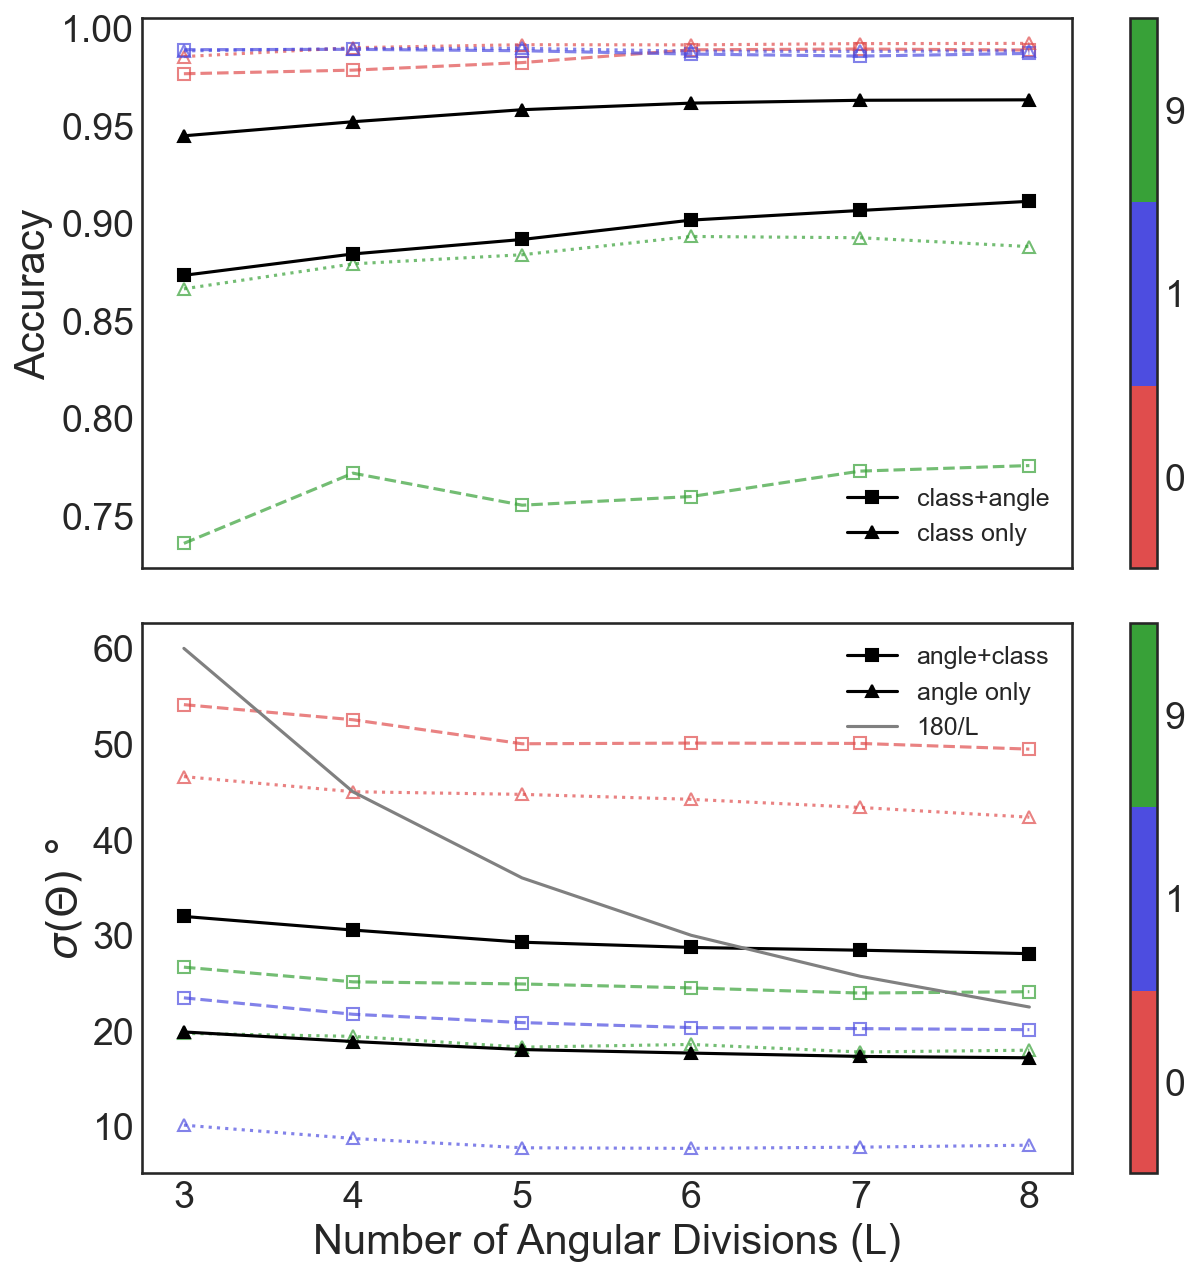

In [557]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(10,10),dpi=150)
ax = fig.add_subplot(211)
angle_range = [0,1,9]
for indx, i in enumerate(angle_range):
    sc = ax.plot(L_list,std_class_both_L[:,3,i,7],'--s',color=cmap_AKS[indx],alpha=0.7,mfc='none')
for indx, i in enumerate(angle_range):
    sc = ax.plot(L_list,np.mean(std_class_ref_L[:,:,i,2],axis=1),':^',color=cmap_AKS[indx],alpha=0.7,mfc='none')

plt.plot(L_list,np.mean(std_class_both_L[:,3,:,7],axis=1),'-s',color='k',label='class+angle')
plt.plot(L_list,np.mean(np.mean(std_class_ref_L[:,:,:,2],axis=1),axis=1),'-^',color='k',label='class only')
# cbar = ax.figure.colorbar(
#             mpl.cm.ScalarMappable(norm=norm, cmap='Spectral'),
#             boundaries=np.arange(11)-0.5,
#             ax=ax, pad=.05).set_ticks(np.arange(10))  

norm2 = mpl.colors.Normalize(vmin=0,vmax=3)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm2, cmap=cmap_bar),
            boundaries=np.arange(4)-0.5,
            ax=ax, ticks=[0,1,2])
cbar.ax.set_yticklabels([0,1,9])
plt.xticks([])

plt.legend()

plt.ylabel('Accuracy')

ax = fig.add_subplot(212)
for indx, i in enumerate(angle_range):
    sc = ax.plot(L_list,std_class_both_L[:,3,i,6],'--s',color=cmap_AKS[indx],alpha=0.7,mfc='none')
for indx, i in enumerate(angle_range):
    sc = ax.plot(L_list,std_class_L[:,3,i,4],':^',color=cmap_AKS[indx],alpha=0.7,mfc='none')

plt.plot(L_list,np.mean(std_class_both_L[:,3,:,6],axis=1),'-s',color='k',label='angle+class')
plt.plot(L_list,np.mean(std_class_L[:,3,:,4],axis=1),'-^',color='k',label='angle only')
plt.plot(L_list,180/np.array(L_list),'-',color='grey',label='180/L')
# cbar = mpl.colorbar.ColorbarBase(ax=ax,
#             cmap = cmap_bar,
#             boundaries=np.arange(4)-0.5,
#             ).set_ticks(np.arange(3))

#cbar = plt.colorbar(sc, ticks=[0.5,1.5,2.5])
norm2 = mpl.colors.Normalize(vmin=0,vmax=3)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm2, cmap=cmap_bar),
            boundaries=np.arange(4)-0.5,
            ax=ax, ticks=[0,1,2])
cbar.ax.set_yticklabels([0,1,9])

plt.legend()

plt.xlabel('Number of Angular Divisions (L)')
plt.ylabel('$\sigma(\Theta)$ $\degree$')
fig.subplots_adjust(hspace=0.1,wspace=0.12)
plt.savefig('../figures/LSeries.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Not worth a figure to show delta dependence. Split the equivariance figure into 2 with the cubic spline fit.

In [441]:
ext_y = hd5_open('../from_cannon/2021_03_09/equivFit.h5','ext_y')
real_y = hd5_open('../from_cannon/2021_03_09/equivFit.h5','real_y')
y_interp = hd5_open('../from_cannon/2021_03_09/equivFit.h5','y_interp')
x_interp = hd5_open('../from_cannon/2021_03_09/equivFit.h5','x_interp')
x_for_compare = hd5_open('../from_cannon/2021_03_09/equivFit.h5','x_for_compare')
shifted_coeff = hd5_open('../from_cannon/2021_03_09/equivFit.h5','shifted_coeff')

In [442]:
x_for_compare = np.append(x_for_compare[-1]-180,x_for_compare)
real_y = np.vstack((real_y[-1,:].reshape(1,real_y.shape[1]),real_y))
ext_y = np.vstack((ext_y[-1,:].reshape(1,ext_y.shape[1]),ext_y))

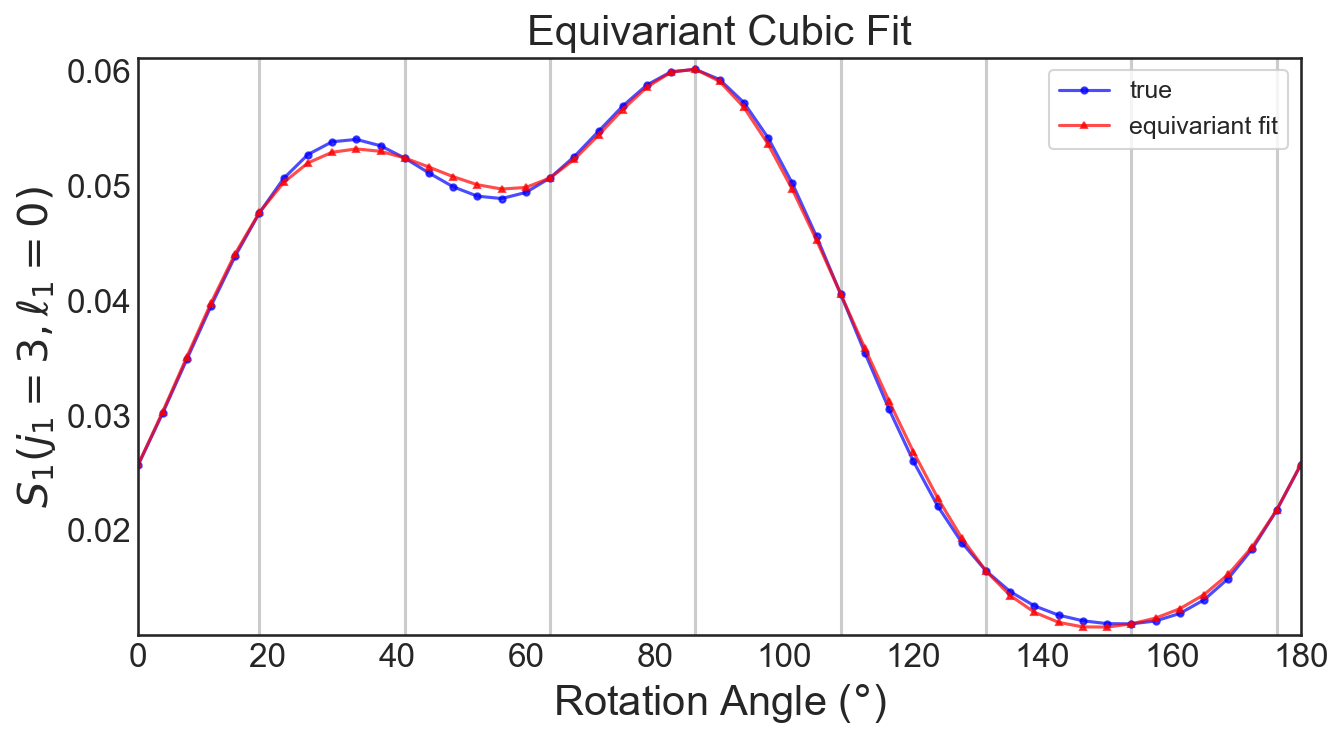

In [468]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')


rcParams['legend.frameon'] = True

fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
j1 = 2
l1 = 0

data = real_y[:,2+5*l1+j1]
plt.plot(x_for_compare,data,'-o',label='true',color='b',alpha=0.7,ms=3)

data1 = ext_y[:,2+5*l1+j1]
plt.plot(x_for_compare,data1,'-^',label='equivariant fit',color='r',alpha=0.7,ms=3)

min_y = data.min()
max_y = data.max()

for i in np.remainder(x_interp[:-1],180):
    plt.vlines(i,min_y-1,max_y+1,'k',alpha=0.2)

plt.title('Equivariant Cubic Fit')
plt.xlabel('Rotation Angle ($\degree$)')
plt.ylabel('$S_1(j_1=3,\ell_1=0)$')
plt.xlim([0,180])
plt.ylim(min_y-1e-3,max_y+1e-3)
plt.legend(facecolor="white")
plt.savefig('../figures/EquivarFit.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

ML Figures

In [32]:
drop_test = np.zeros((10,3,309))
for i in range(10):
    for j in range(3):
        if j==0:
            drop_test[i,j,:] = hd5_open('../../DHC/from_cannon/2021_03_17/drop_test_{}.h5'.format(i),'drop_indx')
        if j==1:
            drop_test[i,j,:] = hd5_open('../../DHC/from_cannon/2021_03_17/drop_test_{}.h5'.format(i),'prec_max')
        if j==2:
            drop_test[i,j,:] = hd5_open('../../DHC/from_cannon/2021_03_17/drop_test_{}.h5'.format(i),'train_prec')

In [17]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

def prec_LDA(X_train,y_train,X_test,y_test,N = 10):
    lda = LDA(n_components=N-1)
    lda.fit(X_train, y_train)
    y_pred_test = lda.predict(X_test)
    y_pred_train = lda.predict(X_train)
    prec_test = precision_score(y_test, y_pred_test,average='micro')
    prec_train = precision_score(y_train, y_pred_train,average='micro')
    return prec_test,prec_train

In [18]:
mnist_train_y = hd5_open('../scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/data/mnist_test_y.h5','main/data')

mnist_DHC_out_sizetrain = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot7pi_8.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot7pi_8_test.h5','main/data')
mnist_DHC_out_sizetest_iso = DHC_iso_vec(mnist_DHC_out_sizetest,6,8)
mnist_DHC_out_sizetrain_iso = DHC_iso_vec(mnist_DHC_out_sizetrain,6,8)

In [19]:
combo_mnist_iso_x = np.vstack((mnist_DHC_out_sizetrain_iso,mnist_DHC_out_sizetest_iso))
combo_mnist_iso_y = np.hstack((mnist_train_y,mnist_test_y))

In [20]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

In [21]:
prec_mnist_test = []
prec_mnist_train = []
for i in np.linspace(0.01,0.90,90):
    X_train, X_test, y_train, y_test = train_test_split(
        combo_mnist_iso_x, 
        combo_mnist_iso_y, 
        stratify=combo_mnist_iso_y, 
        train_size=i,
        test_size=0.1,
        random_state=int(i*10000))

    prec_test_tmp, prec_train_tmp = prec_LDA(X_train,y_train,X_test,y_test)
    prec_mnist_test.append(prec_test_tmp)
    prec_mnist_train.append(prec_train_tmp)

In [22]:
mix_vec = np.linspace(0,70000,101)
fract = mix_vec/70000

In [23]:
prec_mnist_test_false= []
prec_mnist_test_clean= []
prec_mnist_train_false = []

a = [i for i in range(70000)]

for i in mix_vec:
    random_y = copy.deepcopy(combo_mnist_iso_y)
    
    indx = np.random.choice(a, size=int(i), replace=False)
    random_y[indx] = np.random.randint(low=0,high=10,size=int(i))
    
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        combo_mnist_iso_x, 
        random_y,
        a,
        stratify=combo_mnist_iso_y, 
        train_size=0.8,
        test_size=0.2,
        random_state=int(i))

    prec_test_tmp_clean, prec_train_tmp_clean = prec_LDA(X_train,y_train,X_test,combo_mnist_iso_y[idx_test])
    prec_test_tmp, prec_train_tmp = prec_LDA(X_train,y_train,X_test,y_test)
    
    prec_mnist_test_false.append(prec_test_tmp)
    prec_mnist_test_clean.append(prec_test_tmp_clean)
    prec_mnist_train_false.append(prec_train_tmp)

In [24]:
X_tr = mnist_DHC_out_sizetrain_iso
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = mnist_DHC_out_sizetest_iso

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(10,600,1):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

In [25]:
sc = StandardScaler()

X_tr = np.log10(mnist_DHC_out_sizetrain_iso)
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = np.log10(mnist_DHC_out_sizetest_iso)

eval_list_log =[]
test_prec_log =[]
train_prec_log =[]
test_prec_class_log = []
rank_log = []

for n in range(10,600,1):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank_log.append(np.linalg.matrix_rank(X))
    eval_list_log.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec_log.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec_log.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class_log.append(np.mean(np.square(vec-Y_test)))

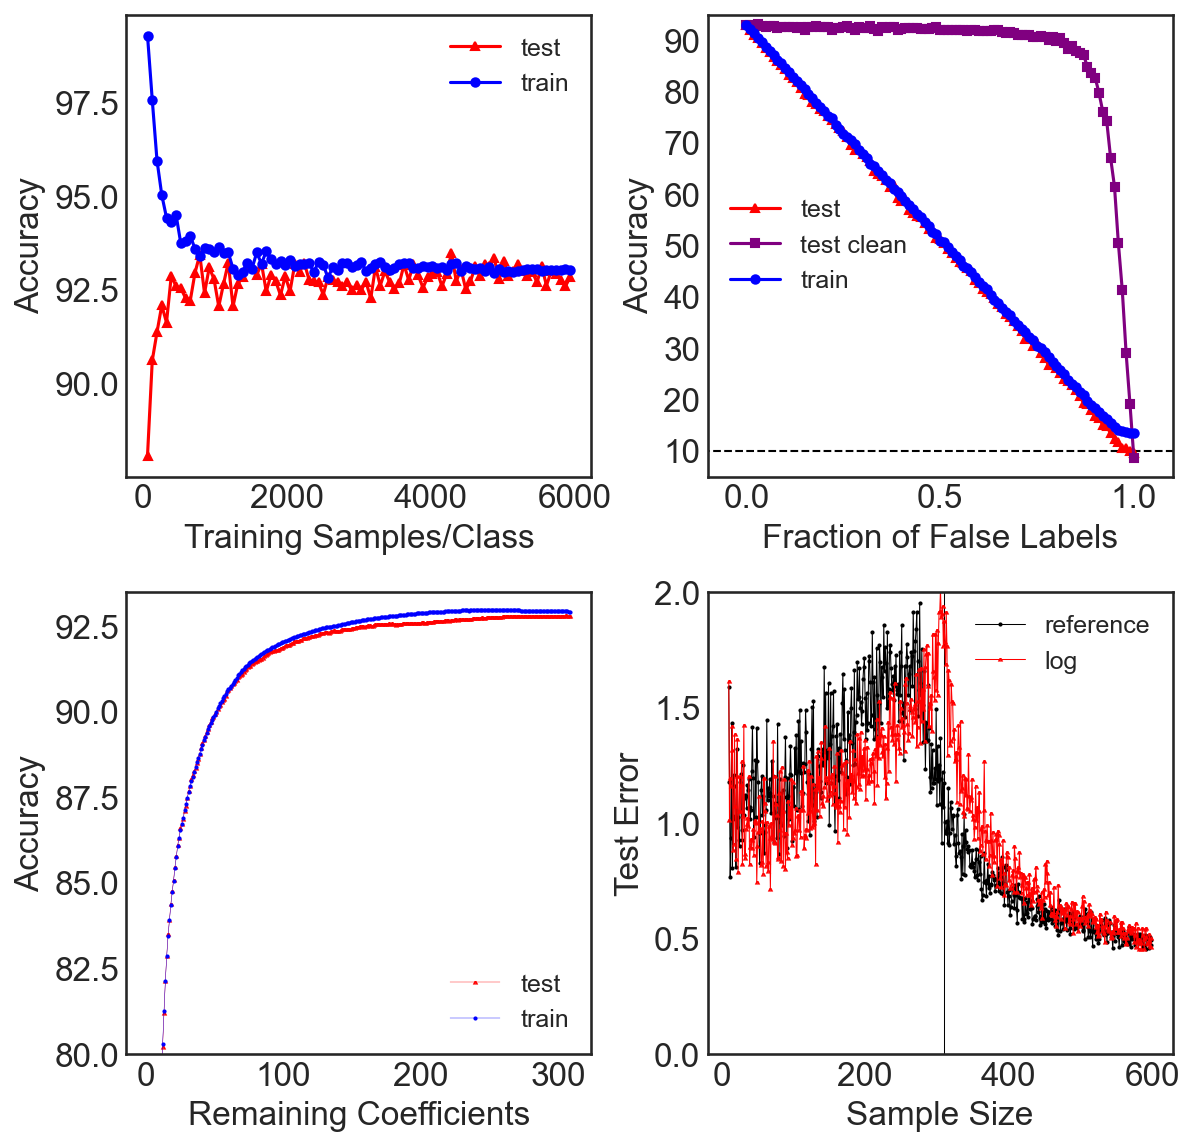

In [56]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 16
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(9,9),dpi=150)

ax = fig.add_subplot(221) 
ax.plot(np.linspace(0.01,0.99,90)*6000,100*np.array(prec_mnist_test), 
        linestyle='-', 
        marker='^',
        color='r',
        ms=4,
        label='test')
ax.plot(np.linspace(0.01,0.99,90)*6000,100*np.array(prec_mnist_train), 
        linestyle='-', 
        marker='o',
        color='b',
        ms=4,
        label='train')
plt.xlabel('Training Samples/Class')
plt.ylabel('Accuracy')
plt.legend()

ax = fig.add_subplot(223)
ax.plot(np.flip(np.arange(310)[1:]),100*np.mean(drop_test,axis=0)[1], color='r', linestyle='-', marker='^',markersize=1,linewidth=.2)
ax.plot(np.flip(np.arange(310)[1:]),100*np.mean(drop_test,axis=0)[2], color='b', linestyle='-', marker='o',markersize=1,linewidth=.2)
plt.xlabel('Remaining Coefficients')
plt.ylabel('Accuracy')
plt.ylim([80,93.5])
plt.legend(['test','train'])

ax = fig.add_subplot(222)
ax.plot(fract,100*np.array(prec_mnist_test_false), 
        linestyle='-', 
        marker='^',
        color='r',
        ms=4,
        label='test')
ax.plot(fract,100*np.array(prec_mnist_test_clean), 
        linestyle='-', 
        marker='s',
        color='purple',
        ms=4,
        label='test clean')
ax.plot(fract,100*np.array(prec_mnist_train_false), 
        linestyle='-', 
        marker='o',
        color='b',
        ms=4,
        label='train')
plt.xlabel('Fraction of False Labels')
plt.ylabel('Accuracy')
plt.hlines(10,-0.2,1.2,'k',linewidth=1,linestyle='--')
plt.ylim([5,95])
plt.xlim([-0.1,1.1])
plt.legend(loc='center left')
plt.yticks(np.arange(10, 100, 10))

ax = fig.add_subplot(224) 
ax.plot([n for n in range(10,600,1)],test_prec, 
        linestyle='-', 
        marker='o',
        color='k',
        label='reference',
        markersize=1,
        linewidth=0.5)
ax.plot([n for n in range(10,600,1)],test_prec_log, 
        linestyle='-', 
        marker='^',
        color='r',
        label='log',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
plt.ylim([0, 2])
plt.legend()
plt.vlines(310,0,4,'k',linewidth=0.5)
fig.subplots_adjust(hspace=0.25,wspace=0.25)
plt.savefig('../figures/MLQA.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [29]:
fract[np.array(prec_mnist_test_clean) < .9]

array([0.8 , 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [69]:
np.flip(np.arange(310)[1:])[100*np.mean(drop_test,axis=0)[1] >100*np.mean(drop_test,axis=0)[1][0]-1]

array([309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297,
       296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284,
       283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271,
       270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258,
       257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245,
       244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232,
       231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219,
       218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 208, 207, 206,
       205, 204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 193,
       192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180,
       179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167,
       166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154,
       153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141,
       140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 12

In [66]:
100*np.mean(drop_test,axis=0)[2][0]

92.91839285714285

Appendix Figures

In [91]:
import scipy.io as sio

In [89]:
from kymatio.scattering2d.filter_bank import filter_bank

M = 256
J = 8
L = 8
filters_set = filter_bank(M, M, J, L=L)

In [93]:
matfilters = sio.loadmat('/Users/saydjari/Dropbox/GradSchool_AKS/Doug/PythonRepos/phaseharmonics-master/matlab/filters/bumpsteerableg1_fft2d_N256_J8_L8.mat')

fftphi = matfilters['filt_fftphi'].astype(np.complex_)
hatphi = np.stack((np.real(fftphi), np.imag(fftphi)), axis=-1)

fftpsi = matfilters['filt_fftpsi'].astype(np.complex_)
hatpsi = np.stack((np.real(fftpsi), np.imag(fftpsi)), axis=-1)

In [94]:
def finklet(j, l):
    # -------- define coordinates
    nx = 256
    xbox = np.linspace(-nx/2, nx/2-1 , nx, dtype=np.float64)    # make a 256x256 grid of X
    sx, sy = np.meshgrid(xbox, xbox, indexing='ij')
    r  = np.sqrt(sx**2 + sy**2)
    theta = np.arctan2(sy, sx)
    logr = np.log2(r, out=np.zeros_like(r), where=(r!=0))
    # -------- in Fourier plane, envelope of psi_j,l
    jrad = 7-j                                 # I think this should be 7-j or something. 
    dtheta = np.pi/8                               # 8 angular bins hardwired
    theta_l = dtheta*l
    mask = np.logical_and(abs(theta-np.pi/2+theta_l) <= dtheta,(abs(logr-jrad) <= 1))
    # -------- angular part
    ang = np.cos((theta-np.pi/2+theta_l)*4)   # rotate by theta_l
    # -------- radial part
    rad = np.cos((logr-jrad)*np.pi/2)
    psi = mask*ang*rad             #mask times angular part times radial part
    return psi

In [95]:
def morlet_2d_AKS_r(M, N, sigma, theta, xi, slant, offset=0, norm=1):
    theta=-theta
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]],dtype=np.double)
    R_inv = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]],dtype=np.double)
    D = np.array([[1, 0], [0, slant * slant]],dtype=np.double)
    curv = np.dot(R, np.dot(D, R_inv)) / ( 2 * sigma * sigma)

    xvec = np.linspace(-M/2, M/2-1, M)
    yvec = np.linspace(-N/2, N/2-1, N)
    [xx, yy] = np.meshgrid(xvec, yvec)
    
    arg = -(curv[0, 0] * np.multiply(xx-xi*np.cos(theta), xx-xi*np.cos(theta)) + 
            (curv[0, 1] + curv[1, 0]) * np.multiply(xx-xi*np.cos(theta), yy-xi*np.sin(theta)) + 
            curv[1, 1] * np.multiply(yy-xi*np.sin(theta), yy-xi*np.sin(theta)))
    arg1 = -(curv[0, 0] * np.multiply(xx, xx) + 
            (curv[0, 1] + curv[1, 0]) * np.multiply(xx, yy) + 
            curv[1, 1] * np.multiply(yy, yy))
    arg2 = -(curv[0, 0] * np.multiply(xi*np.cos(theta), xi*np.cos(theta)) + 
            (curv[0, 1] + curv[1, 0]) * np.multiply(xi*np.cos(theta), xi*np.sin(theta)) + 
            curv[1, 1] * np.multiply(xi*np.sin(theta), xi*np.sin(theta)))
    return norm*(np.exp(arg)-np.exp(arg1+arg2))

In [99]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

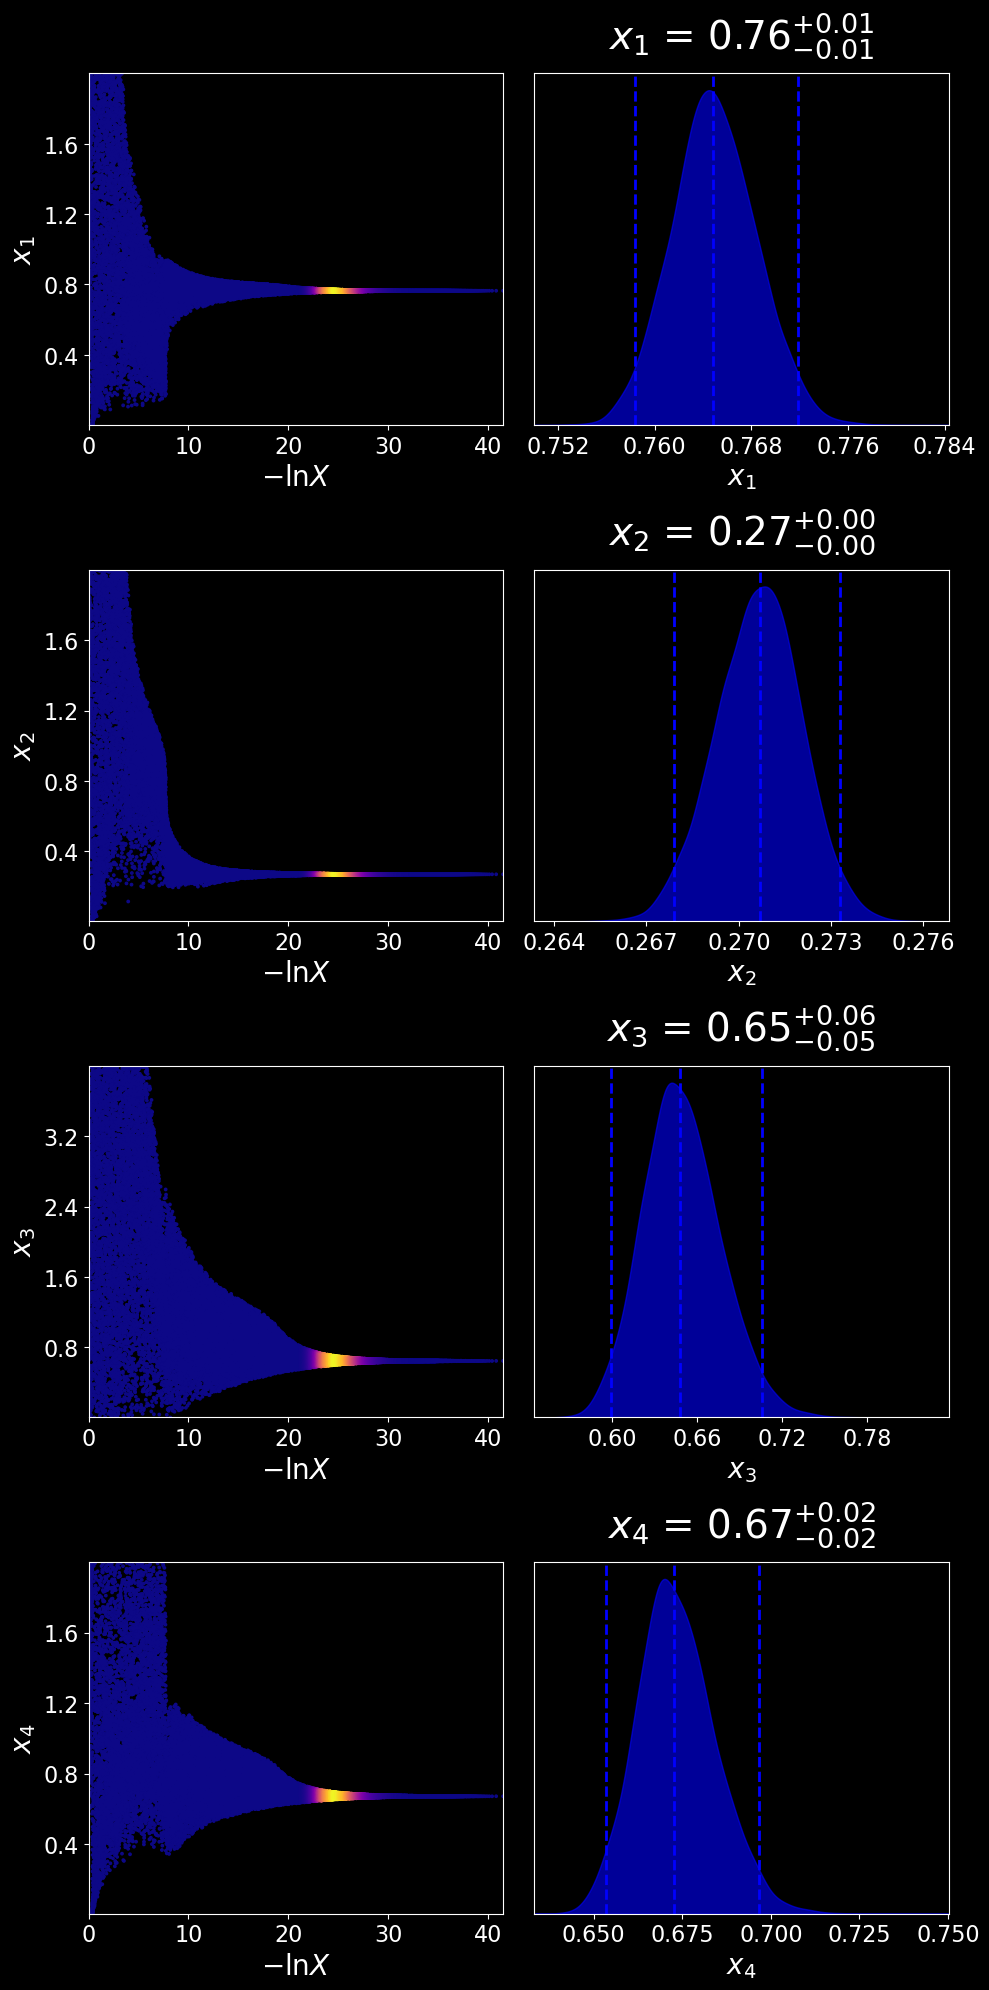

In [114]:
with open('../../IWST/FromCannon/2020_10_29/res_morlet_cfree_scat7_acom.p', 'rb') as input_file:
    res = pickle.load(input_file)

fig, axes = dyplot.traceplot(res,
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='plasma', kde=False,
                             fig=plt.subplots(4, 2, figsize=(10, 20)))
fig.tight_layout()
plt.show()

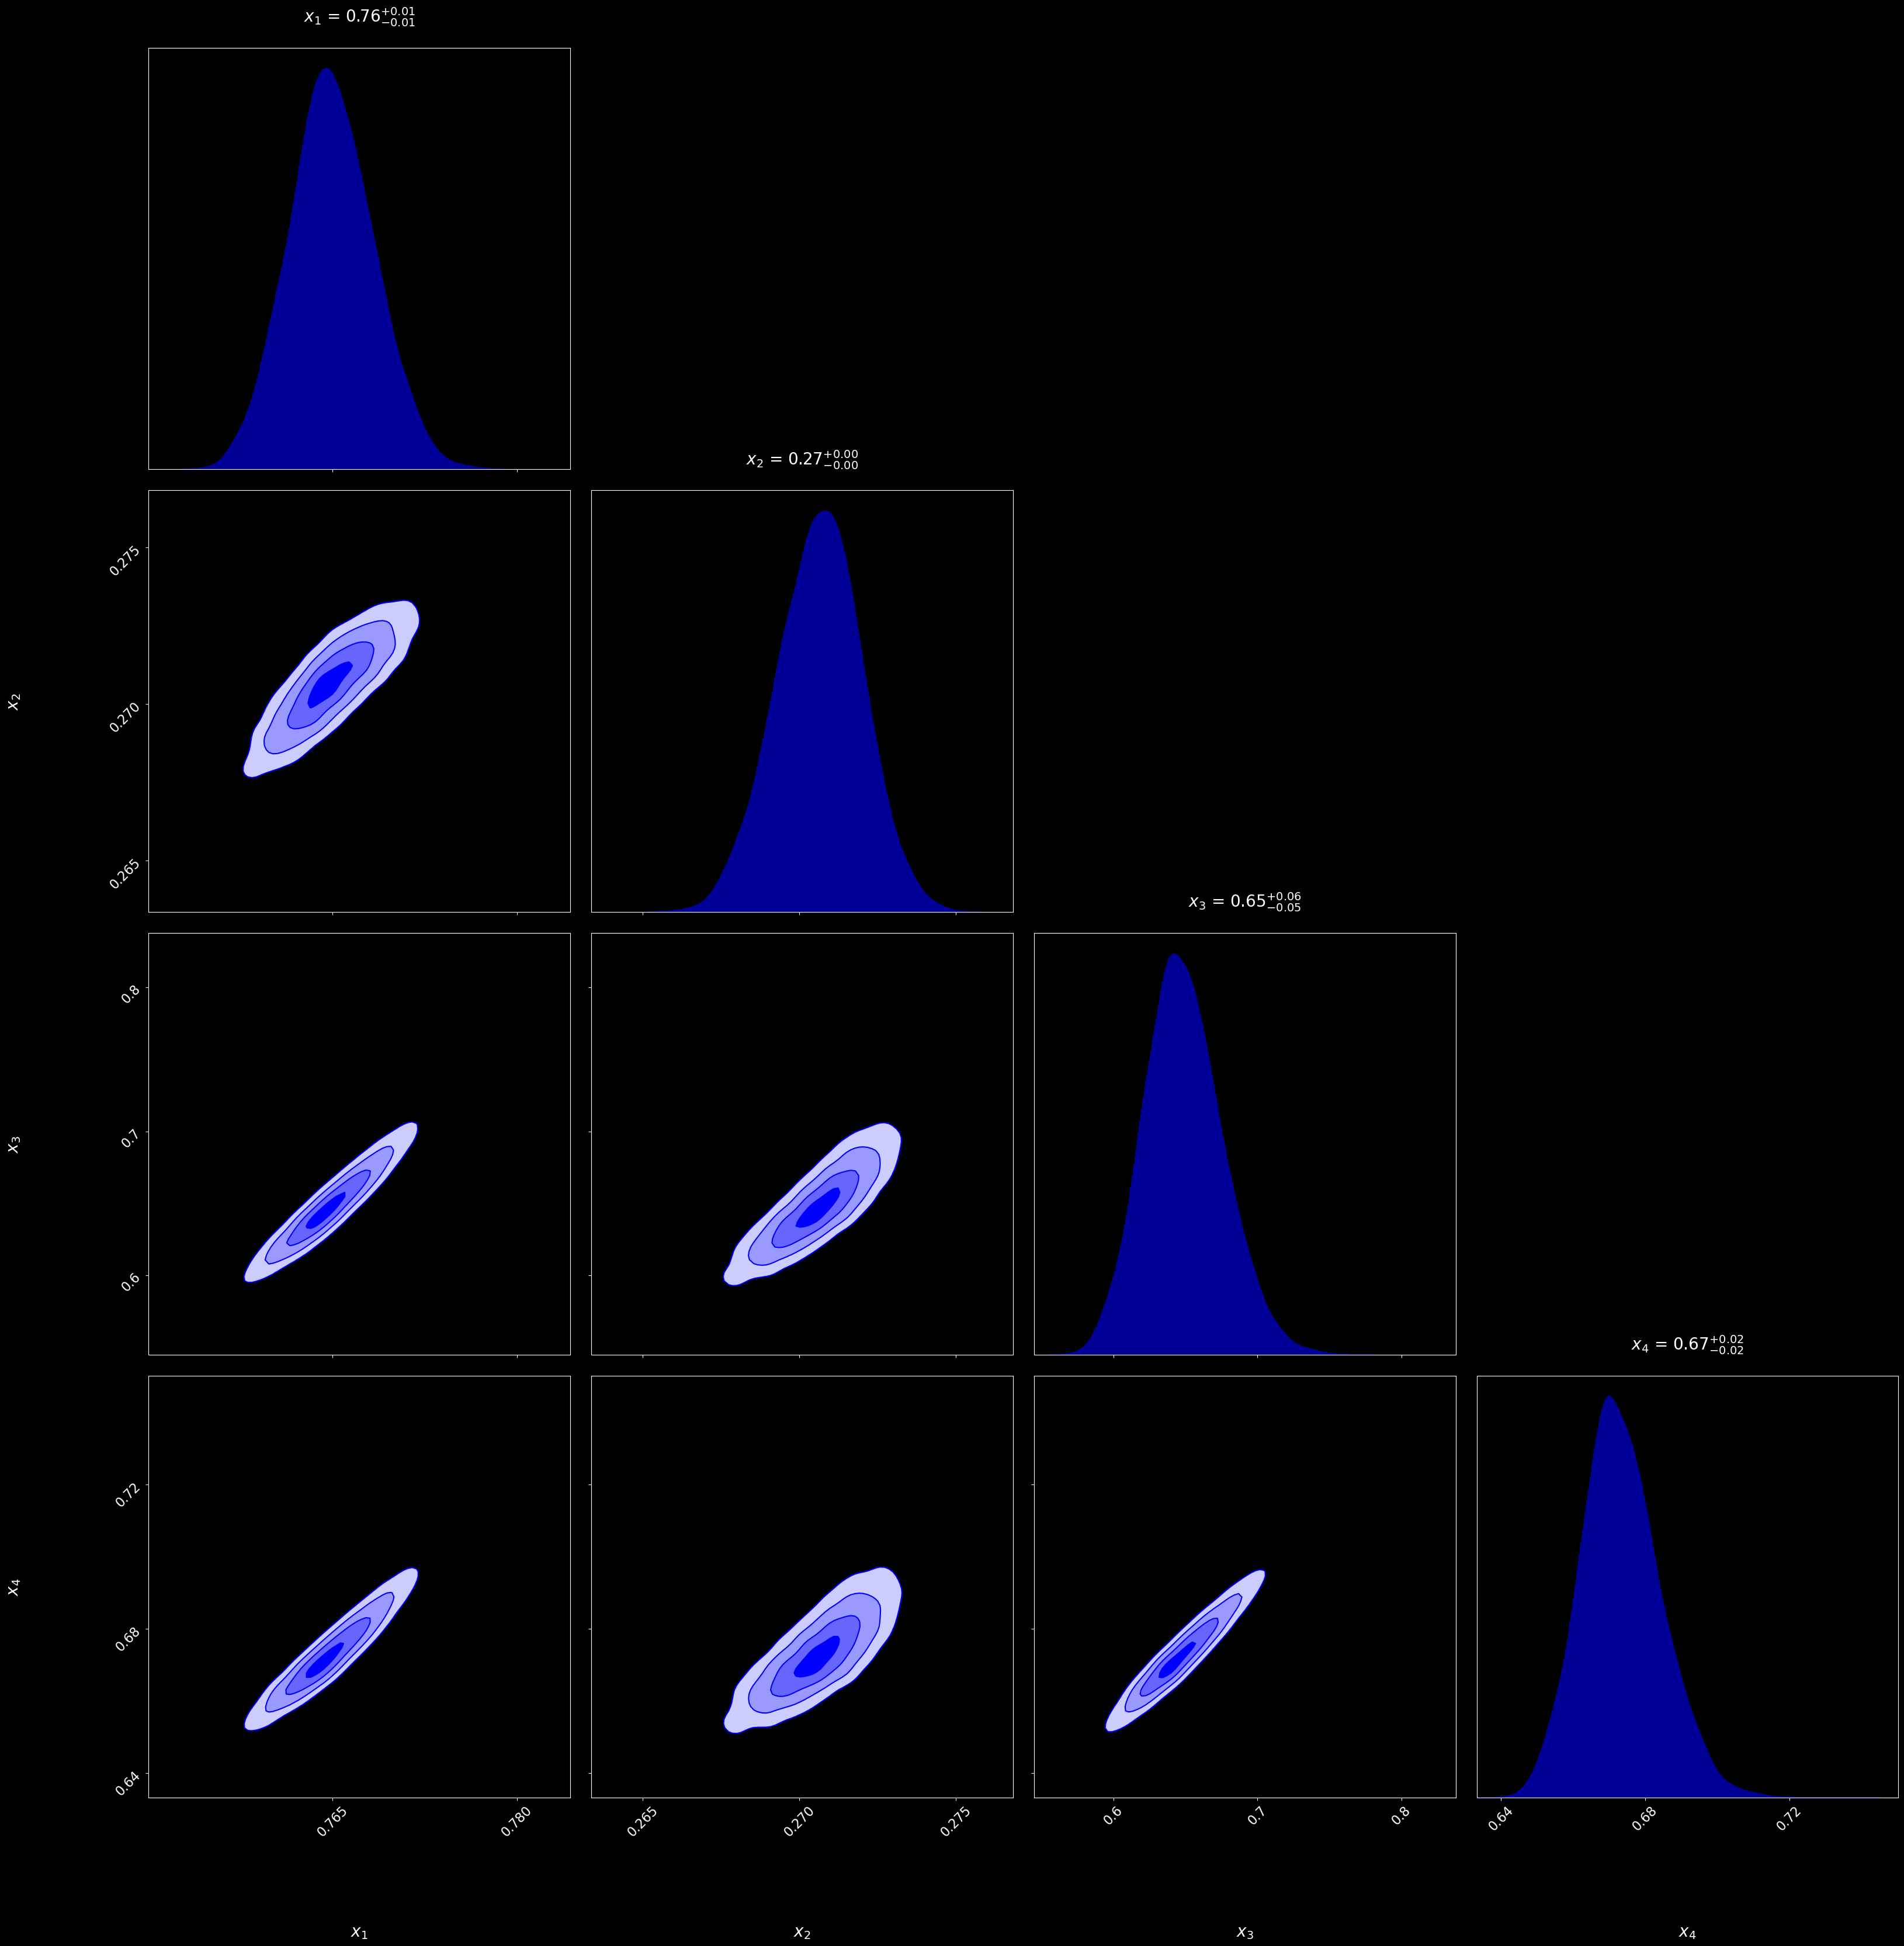

In [115]:
#initialize figure
fig, axes = plt.subplots(4, 4, figsize=(35, 35))
axes = axes.reshape((4, 4))

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue',
                           #truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes))
plt.show()

In [116]:
samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
mean

array([0.76493959, 0.27064265, 0.64922299, 0.67348098])

In [161]:
def self_conj(a):
    return np.real(np.multiply(a,np.conj(a)))

def rotate_180(array):
    out = copy.deepcopy(array)
    M = array.shape[0]
    N = array.shape[1]
    for i in range(M):
        for j in range(N):
            out[i, N-1-j] = array[M-1-i, j]
    return np.roll(out,(1,1),(0,1))

M = 256
N = 256

def grad_wrapper(x):
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    morlet_filter_sum = np.zeros((256,256))
    for j in range(0,J):
        for l in range(L):
            morlet_filter_sum += self_conj(morlet_2d_AKS_r(M, N, b*2**(j),
                    (int(L-L/2)-l) * np.pi / L,
                    a/2**(-j), c, norm=d).T)
    return mean_squared_error(morlet_filter_sum+rotate_180(morlet_filter_sum),circle_ref)

In [162]:
params = mean

a = params[0]
b = params[1]
c = params[2]
d = params[3]

J = 8
L = 8

morlet_filter = np.zeros((8,8,256,256),dtype=np.float64)
morlet_filter_sum = np.zeros((256,256),dtype=np.float64)

fmorlet_filter = np.zeros((J,L,256,256),dtype=np.float64)
fmorlet_filter_sum = np.zeros((256,256),dtype=np.float64)

bump_filter = np.zeros((8,8,256,256),dtype=np.float64)
bump_filter_sum = np.zeros((256,256),dtype=np.float64)

fink_filter = np.zeros((8,8,256,256),dtype=np.float64)
fink_filter_sum = np.zeros((256,256),dtype=np.float64)

for j in range(J):
    for l in range(L):
        morlet_filter[j,l,:,:]=filters_set['psi'][j*8+l][0]
        morlet_filter_sum += self_conj(morlet_filter[j,l].T)
        
        fmorlet_filter[j,l,:,:]=np.fft.fftshift(morlet_2d_AKS_r(M, N, b*2**(8-j),
                                                (int(L-L/2)-l) * np.pi / L - np.pi/2,
                                                a*2**(8-j), c, norm=d))
        fmorlet_filter_sum += self_conj(fmorlet_filter[j,l].T)
        
        bump_filter[j,l,:,:]=hatpsi[j,l,:,:,0]
        bump_filter_sum += self_conj(bump_filter[j,l].T)
        
        fink_filter[j,l,:,:]=np.fft.fftshift(finklet(j,l))
        fink_filter_sum += self_conj(fink_filter[j,l].T)
        
filter_list = [morlet_filter,fmorlet_filter,bump_filter,fink_filter]
filter_list_sum = [morlet_filter_sum,fmorlet_filter_sum,bump_filter_sum,fink_filter_sum]

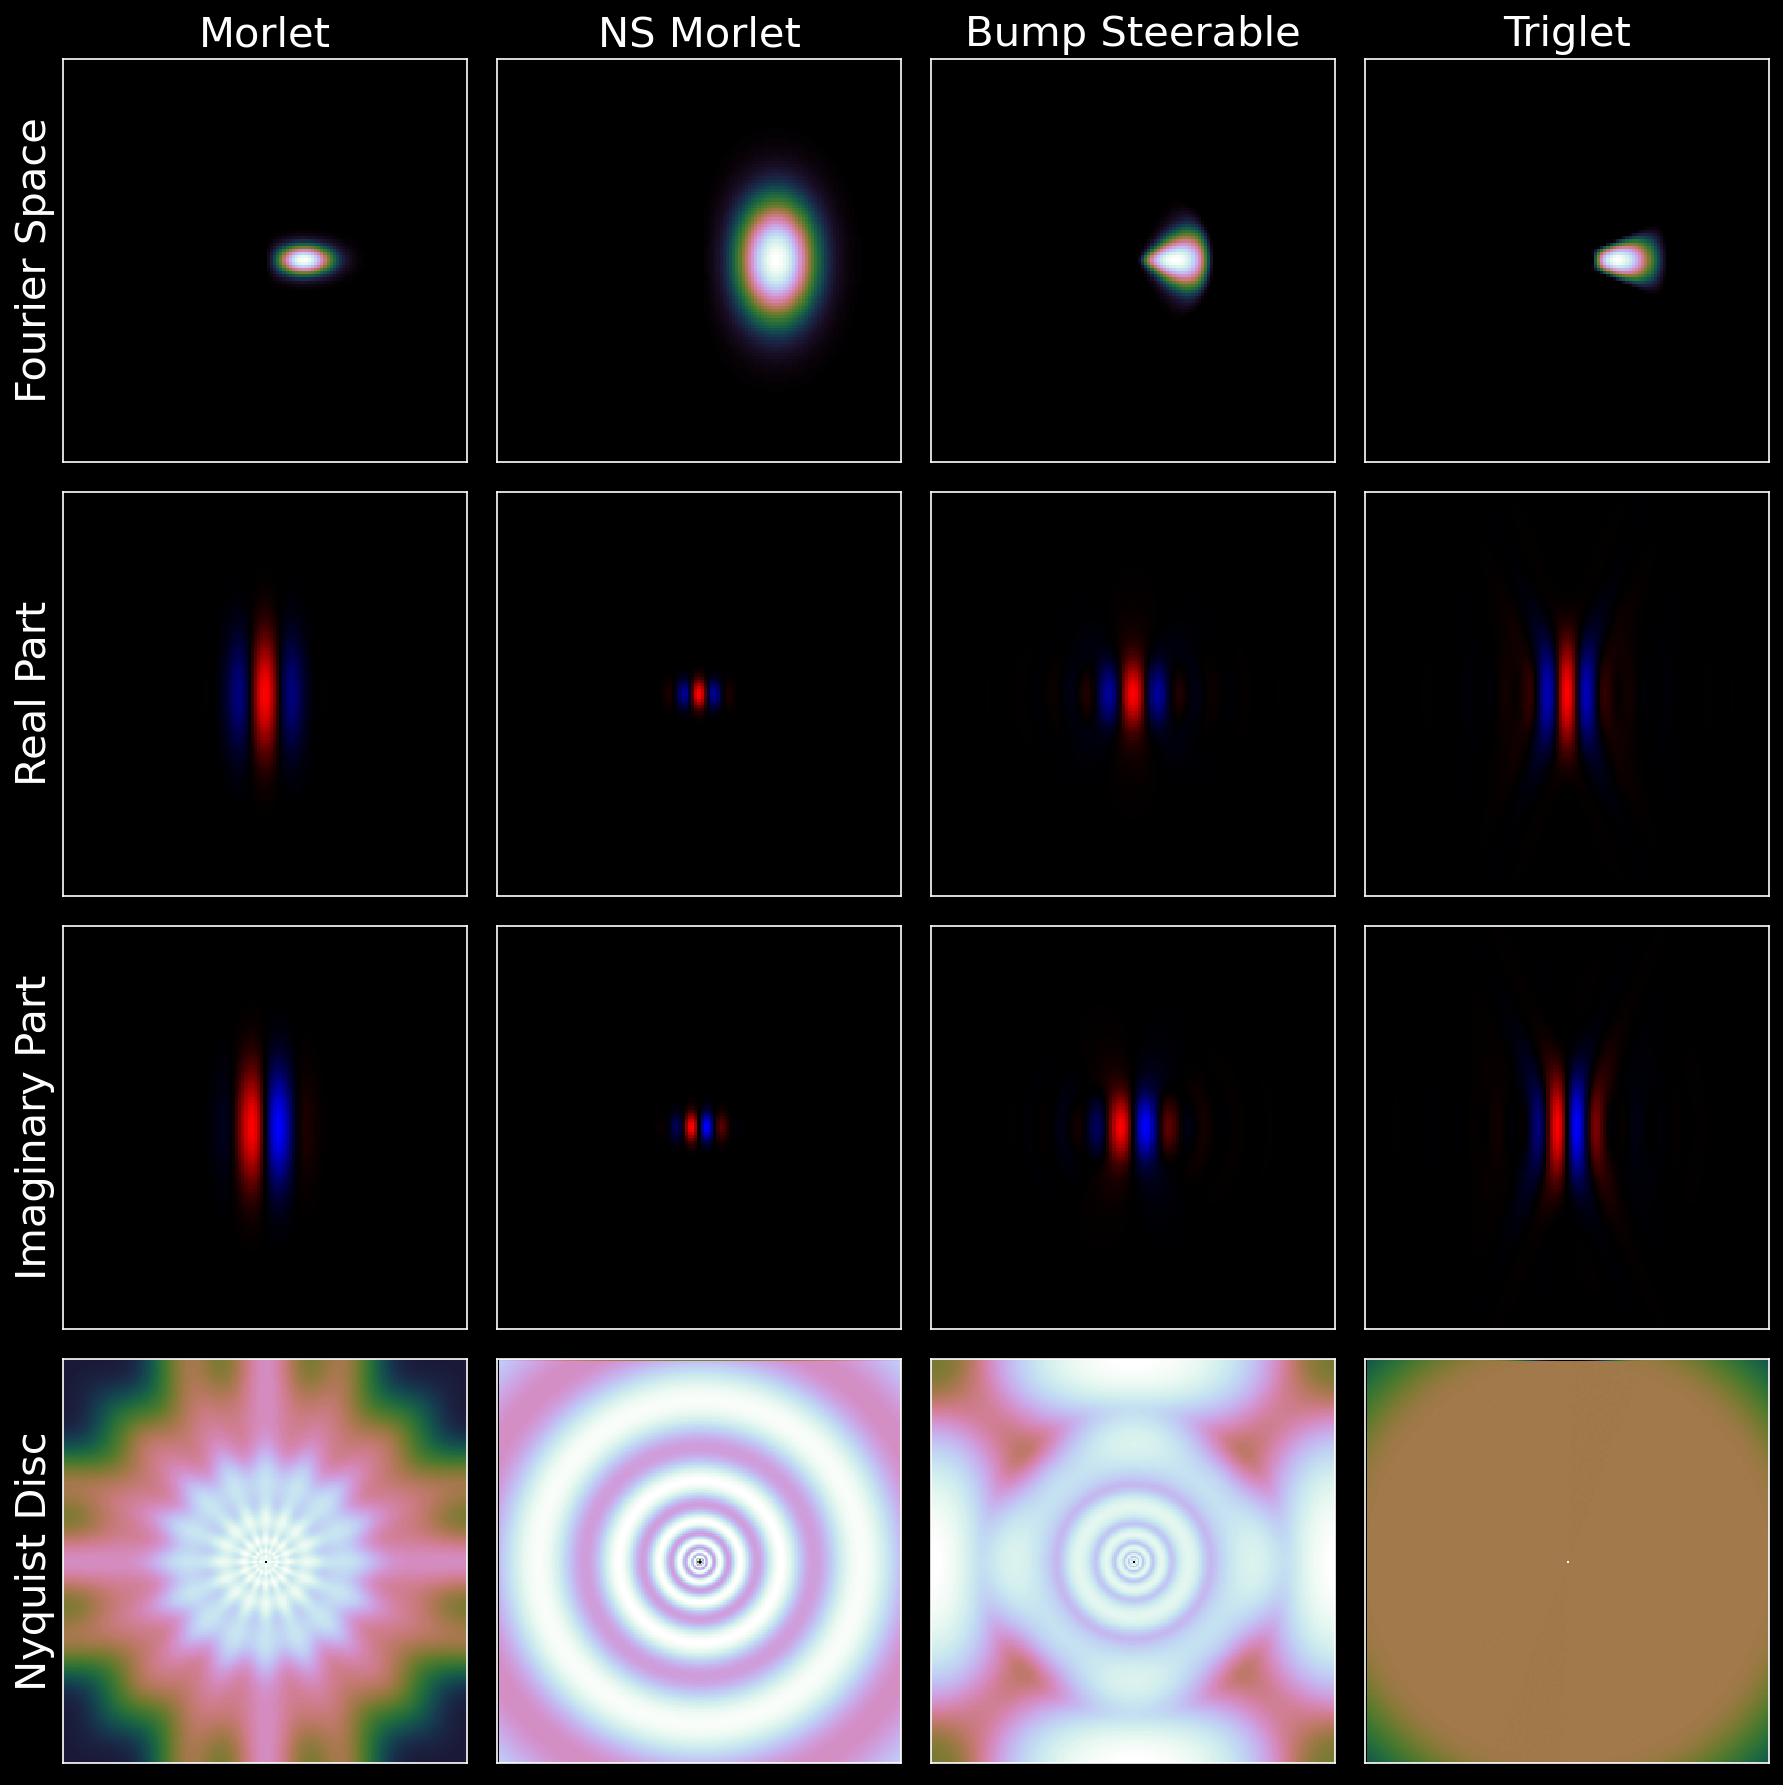

In [164]:
#Figure
fig = plt.figure(figsize=(12,12), dpi=150)
j = 3
l = 4
title_list = ['Morlet', 'NS Morlet', 'Bump Steerable', 'Triglet']
for i in range(len(filter_list)):
    if i == 0:
        wavelet = filter_list[i][j,l-1]
    else:
        wavelet = filter_list[i][j,l]
        
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(
        np.fft.fftshift(wavelet).T,
        vmin=0,
        origin='upper',
        interpolation='nearest',
        cmap='cubehelix',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j+2),128+2**(7-j+2)])
    ax.axes.set_ylim([128-2**(7-j+2),128+2**(7-j+2)])
    if i == 0:
        plt.ylabel('Fourier Space')
    plt.title(title_list[i])
    
    wavelet_fft = np.fft.fftshift(np.fft.fft2(wavelet))

    ax = fig.add_subplot(4,4,i+4*1+1)
    ax.imshow(
        np.real(wavelet_fft.T),
        vmin=-np.real(wavelet_fft.T).max(),
        vmax=np.real(wavelet_fft.T).max(),
        origin='upper',
        interpolation='nearest',
        cmap=blue_red1,
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    if i == 0:
        plt.ylabel('Real Part')

    ax = fig.add_subplot(4,4,i+4*2+1)
    ax.imshow(
        np.imag(wavelet_fft.T),
        origin='upper',
        interpolation='nearest',
        cmap=blue_red1,
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    if i == 0:
        plt.ylabel('Imaginary Part')
        
    ax = fig.add_subplot(4,4,i+4*3+1)
    plt.imshow(
        np.fft.fftshift(filter_list_sum[i]+rotate_180(filter_list_sum[i])),
        vmin=0,
        #vmax=2.2,
        origin='upper',
        #norm=mpl.colors.LogNorm(),
        interpolation='nearest',
        cmap='cubehelix',
        aspect='equal'
    )

    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    if i == 0:
        plt.ylabel('Nyquist Disc')

fig.tight_layout()
plt.show()

In [182]:
params = mean

a = params[0]
b = params[1]
c = params[2]
d = params[3]

J = 8
L = 8

morlet_filter = np.zeros((8,8,256,256),dtype=np.float64)
morlet_filter_sum = np.zeros((256,256),dtype=np.float64)

fmorlet_filter = np.zeros((J,L,256,256),dtype=np.float64)
fmorlet_filter_sum = np.zeros((256,256),dtype=np.float64)

bump_filter = np.zeros((8,8,256,256),dtype=np.float64)
bump_filter_sum = np.zeros((256,256),dtype=np.float64)

fink_filter = np.zeros((8,8,256,256),dtype=np.float64)
fink_filter_sum = np.zeros((256,256),dtype=np.float64)

for j in range(J):
    for l in range(L):
        morlet_filter[j,l,:,:]=filters_set['psi'][j*8+l][0]
        morlet_filter_sum += np.abs(morlet_filter[j,l].T)
        
        fmorlet_filter[j,l,:,:]=np.fft.fftshift(morlet_2d_AKS_r(M, N, b*2**(8-j),
                                                (int(L-L/2)-l) * np.pi / L - np.pi/2,
                                                a*2**(8-j), c, norm=d))
        fmorlet_filter_sum += self_conj(fmorlet_filter[j,l].T)
        
        bump_filter[j,l,:,:]=hatpsi[j,l,:,:,0]
        bump_filter_sum += np.abs(bump_filter[j,l].T)
        
        fink_filter[j,l,:,:]=np.fft.fftshift(finklet(j,l))
        fink_filter_sum += self_conj(fink_filter[j,l].T)
        
filter_list = [morlet_filter,fmorlet_filter,bump_filter,fink_filter]
filter_list_sum = [morlet_filter_sum,fmorlet_filter_sum,bump_filter_sum,fink_filter_sum]
filter_list_summax = [filter_list_sum[0].max(),filter_list_sum[1].max(),filter_list_sum[2].max(),1.0]

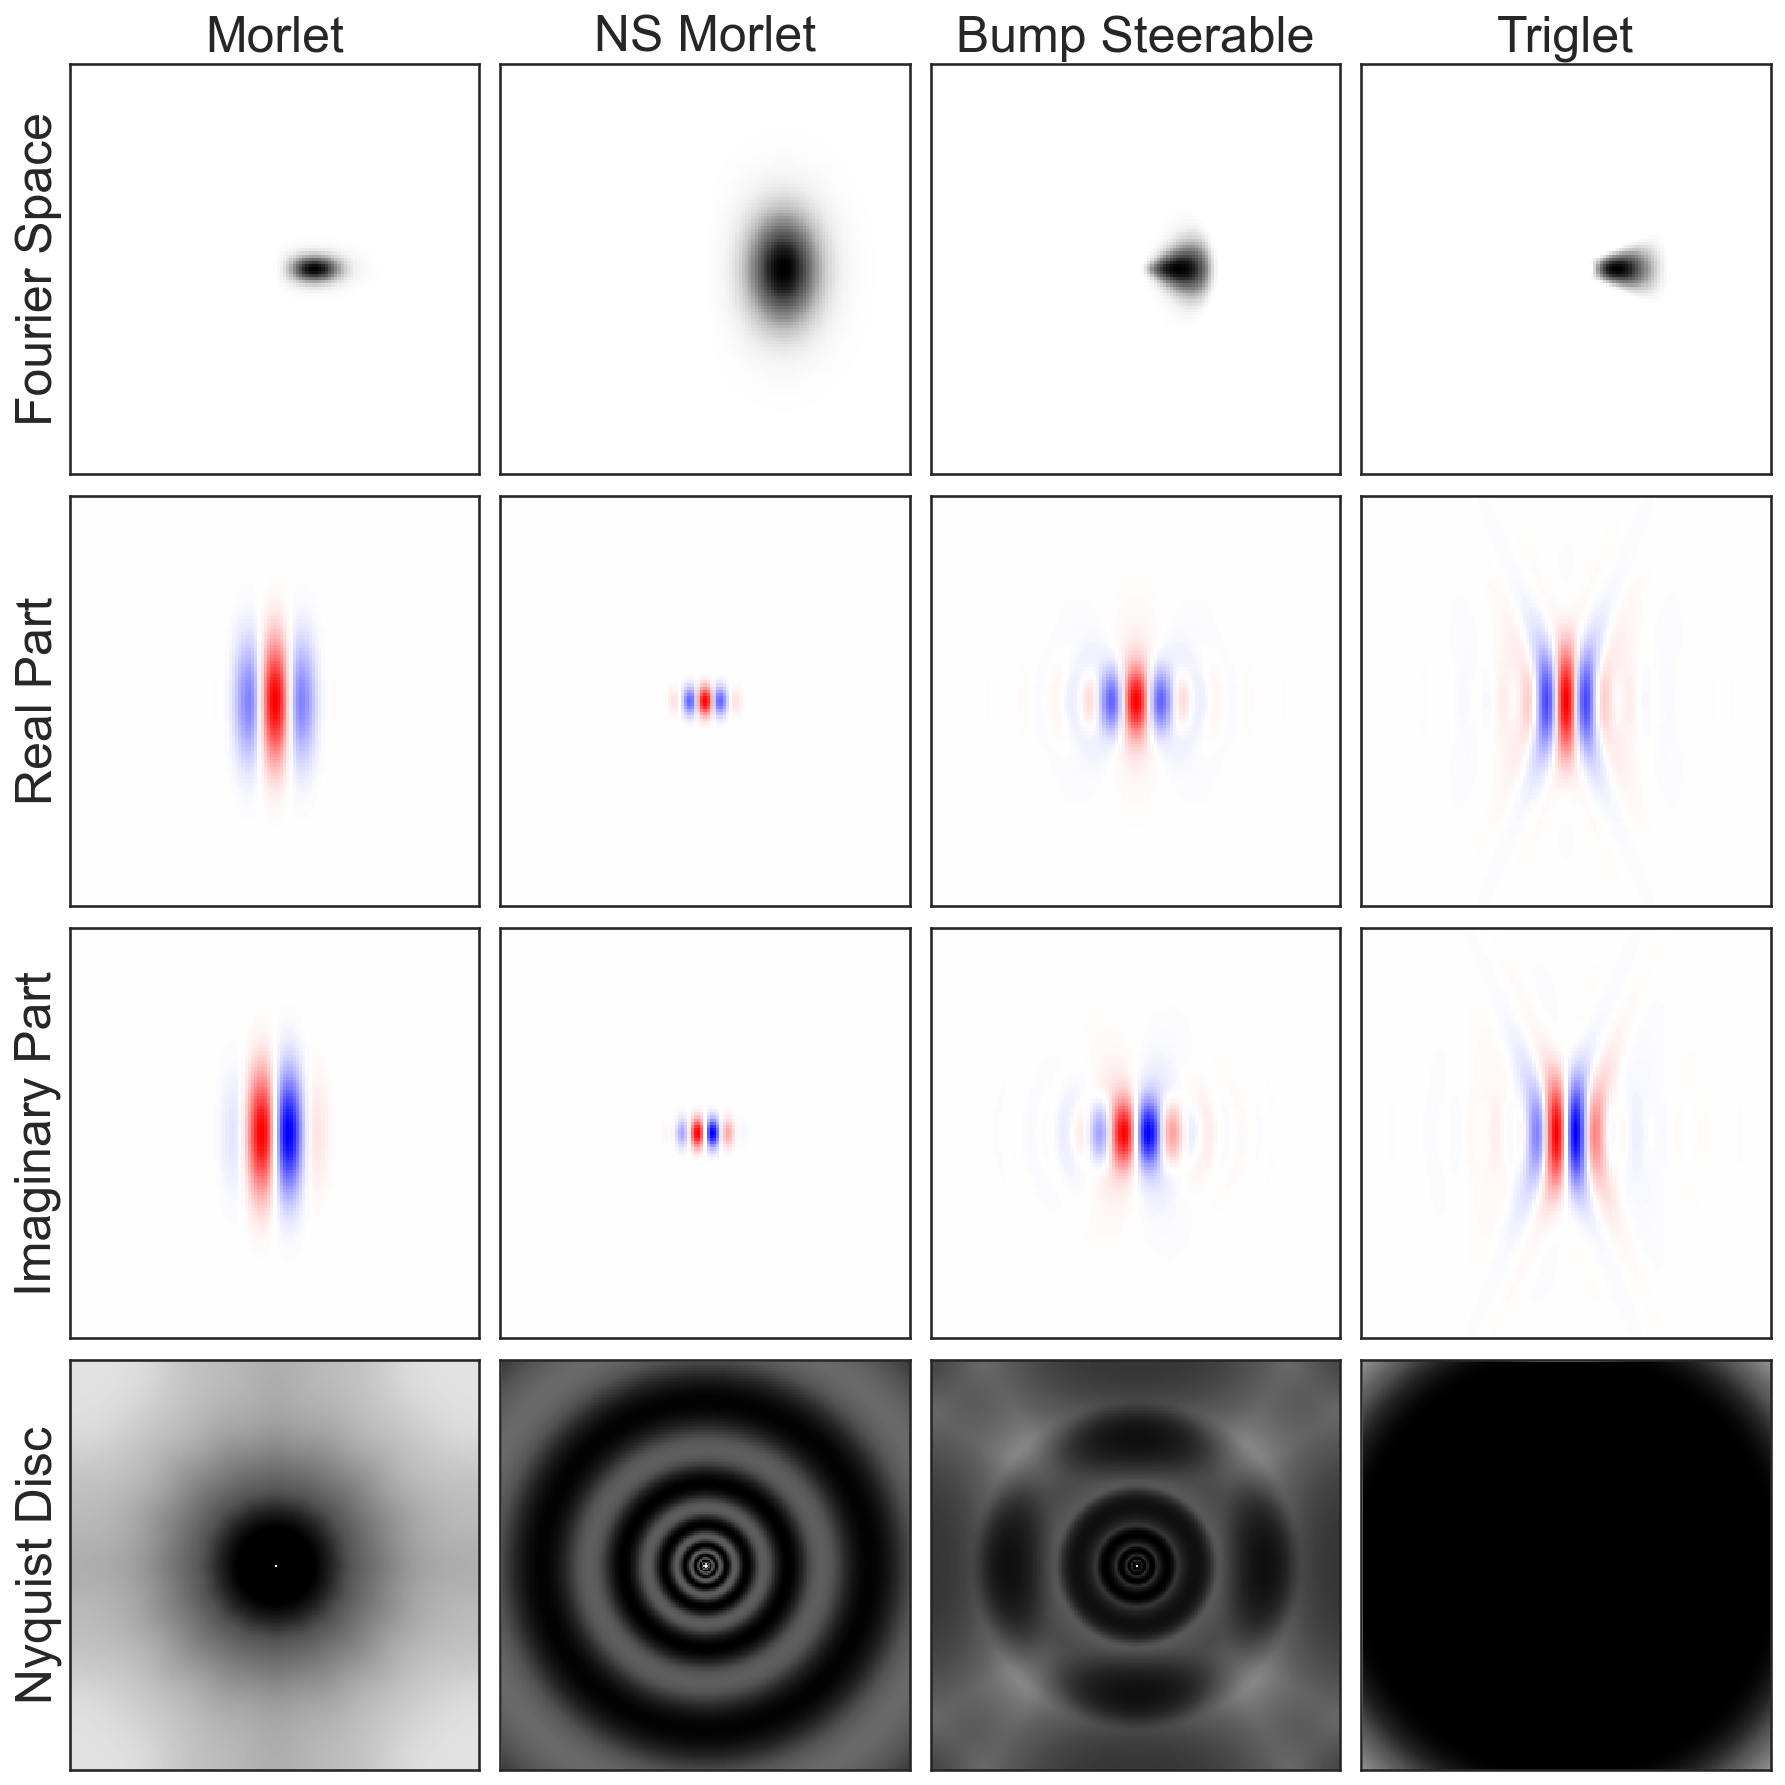

In [193]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

#Figure
fig = plt.figure(figsize=(12,12), dpi=150)
j = 3
l = 4
title_list = ['Morlet', 'NS Morlet', 'Bump Steerable', 'Triglet']
for i in range(len(filter_list)):
    if i == 0:
        wavelet = filter_list[i][j,l-1]
    else:
        wavelet = filter_list[i][j,l]
        
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(
        np.fft.fftshift(wavelet).T,
        vmin=0,
        origin='upper',
        interpolation='nearest',
        cmap='Greys',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j+2),128+2**(7-j+2)])
    ax.axes.set_ylim([128-2**(7-j+2),128+2**(7-j+2)])
    if i == 0:
        plt.ylabel('Fourier Space')
    plt.title(title_list[i])
    
    wavelet_fft = np.fft.fftshift(np.fft.fft2(wavelet))

    ax = fig.add_subplot(4,4,i+4*1+1)
    ax.imshow(
        np.real(wavelet_fft.T),
        vmin=-np.real(wavelet_fft.T).max(),
        vmax=np.real(wavelet_fft.T).max(),
        origin='upper',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    if i == 0:
        plt.ylabel('Real Part')

    ax = fig.add_subplot(4,4,i+4*2+1)
    ax.imshow(
        np.imag(wavelet_fft.T),
        origin='upper',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    if i == 0:
        plt.ylabel('Imaginary Part')
        
    ax = fig.add_subplot(4,4,i+4*3+1)
    plt.imshow(
        np.fft.fftshift(filter_list_sum[i]+rotate_180(filter_list_sum[i])),
        vmin=0,
        vmax=filter_list_summax[i],
        origin='upper',
        #norm=mpl.colors.LogNorm(),
        interpolation='nearest',
        cmap='Greys',
        aspect='equal'
    )

    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    if i == 0:
        plt.ylabel('Nyquist Disc')

fig.tight_layout()
plt.savefig('../figures/WaveletCompare.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [195]:
mnist_train_y = hd5_open('../scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/data/mnist_test_y.h5','main/data')
mnist_DHC_out = hd5_open('../scratch_AKS/data/mnist_DHC_out.h5','main/data')
mnist_DHC_out_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_test.h5','main/data')

In [197]:
def DHC_iso(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [219]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.tab10(norm(i)) for i in label_list]
    color_order = ["white", "black"]
    color_map = "Greys"
    colormap='tab10'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    
    for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
        ytick.set_color(color)

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test Accuracy ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    textcolors=color_order
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", 
                               color=textcolors[int(cmap_normal[i, j] < threshold)],size=16)
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LD_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LD_{}$'.format(i-2))
        plt.ylabel('$LD_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LD_{}$'.format(i-2))
            plt.ylabel('$LD_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.savefig('../figures/MNISTtesttrain.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

In [214]:
mnist_DHC_out_iso = DHC_iso(mnist_DHC_out,6,8)
mnist_DHC_out_test_iso = DHC_iso(mnist_DHC_out_test,6,8)

Accuracy0.935


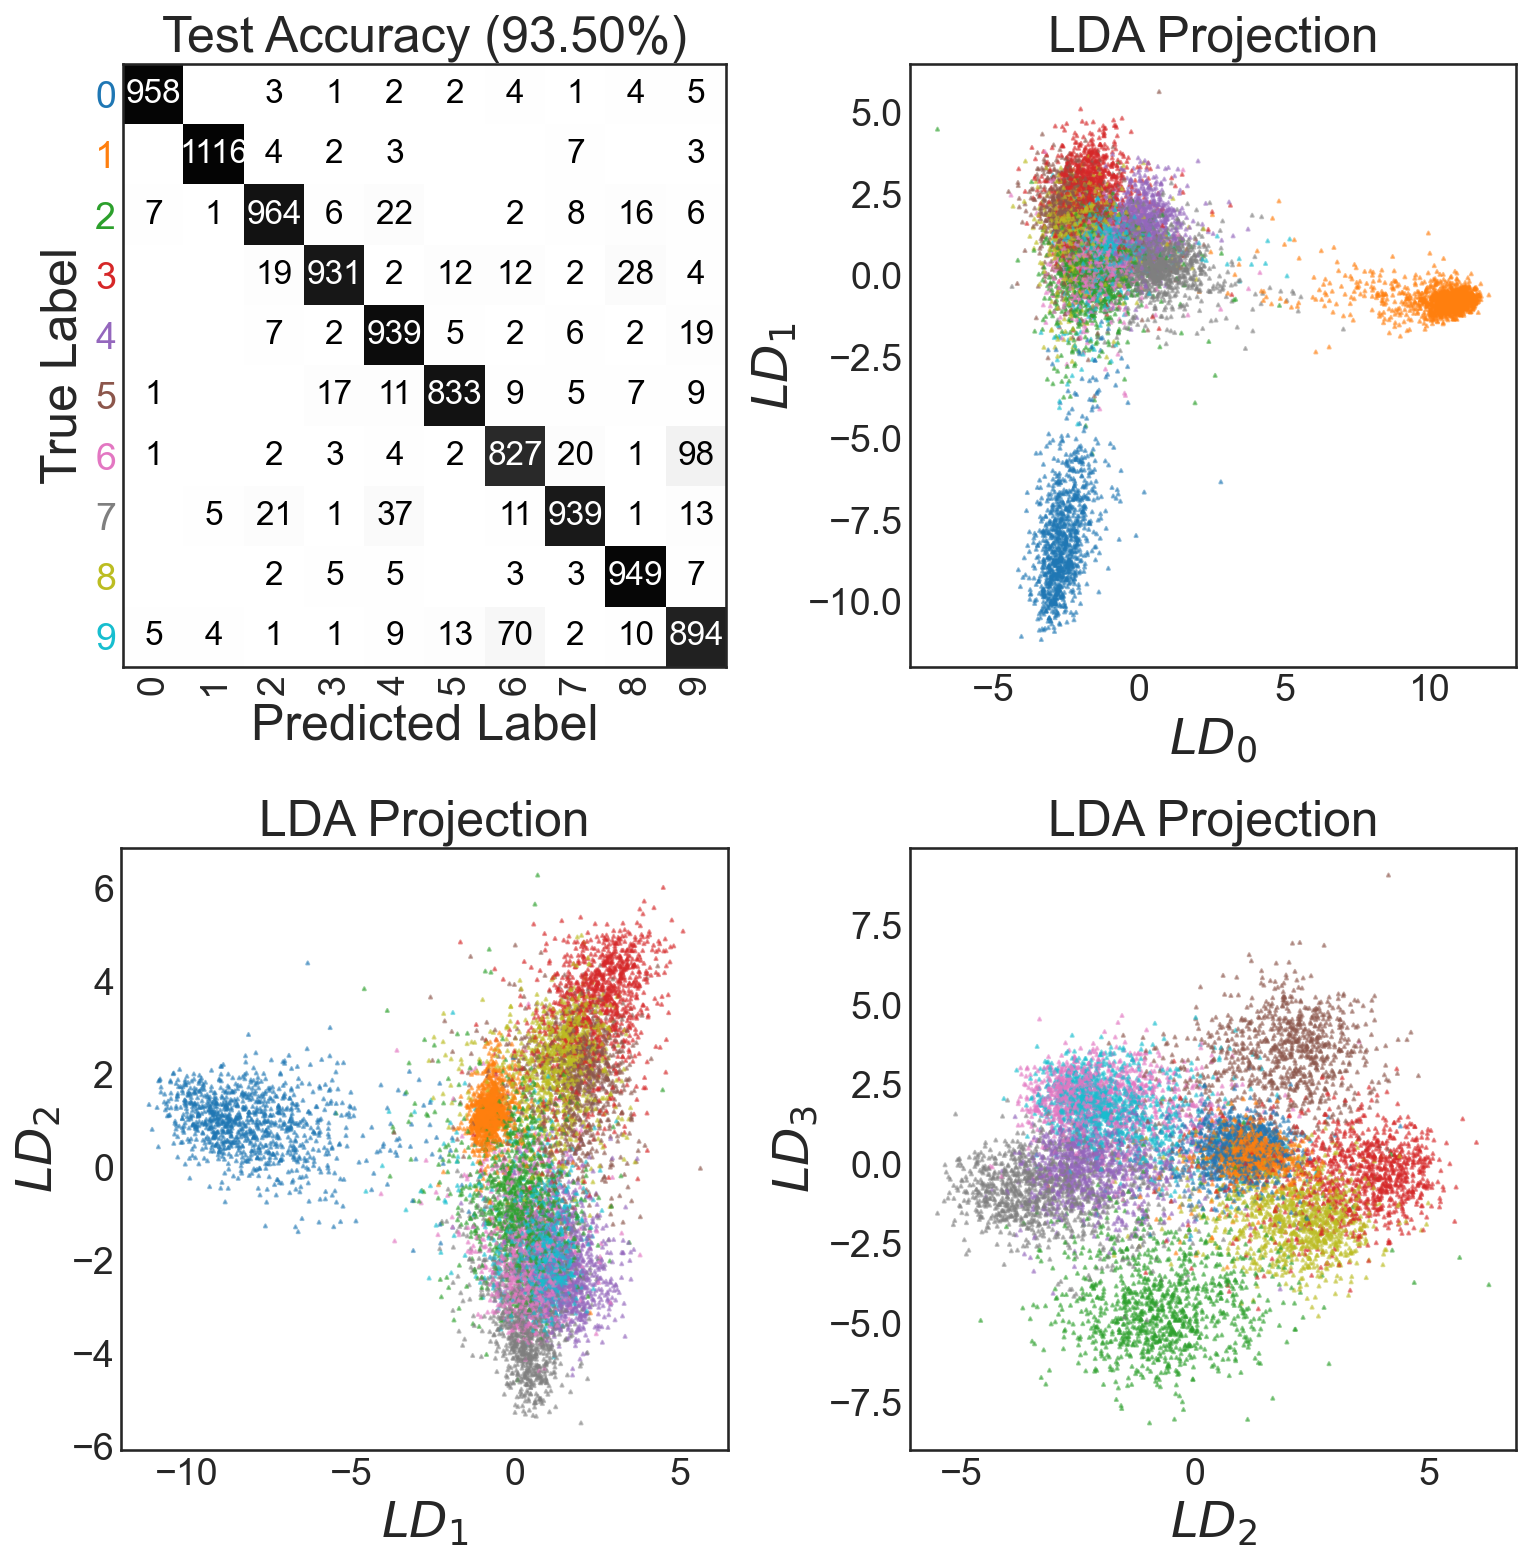

In [220]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_iso,mnist_train_y,mnist_DHC_out_test_iso,mnist_test_y,N-1,labels)
